In [5]:
from utils import *
import os
import glob
import requests
import zipfile
import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
import pickle
import matplotlib as m
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.dates as dates
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Functions

### for data preprocessing

In [6]:
# Convert txt files to csv files
def ratings_text_to_csv():
    """
    Rewrite the ratings txt files in data folder as a csv file.
    ! Don't put any other txt files in the data folder !
    """
    path = r'../data/**/*.txt'
    files = glob.glob(path, recursive=True)

    for file in files:
        ratings_list = []
        rating_dic = {}
        with open(file, encoding= "utf8") as f:
            for i, line in tqdm(enumerate(f)):
                field = line.split(": ")[0]
                if field == "\n":
                    ratings_list.append(rating_dic)
                    rating_dic = {}
                    continue
                content = line.split(": ")[1:]
                content = ": ".join(content)
                rating_dic[field] = content.strip()
                
        ratings = pd.DataFrame.from_dict(ratings_list)
        ratings.to_csv(file.replace('txt', 'csv'), index=False)


# Load csv data
def load_data(dataset, reduced=None):
    assert(dataset in ['ba', 'rb', 'matched', 'pre_ba', 'pre_rb'])
    
    BA_DIR = '../data/BeerAdvocate/'
    RB_DIR = '../data/RateBeer/'
    MATCHED_DIR = '../data/matched_beer_data/'
    PREPROCESSED_BA_DIR = '../data/preprocessed/BeerAdvocate/'
    PREPROCESSED_RB_DIR = '../data/preprocessed/RateBeer/'

    if reduced is None:
        reduced=1e15 # Assume no dataset longer than this value

    # Load BeerAdvocate dataset
    if dataset=='ba':
        beers_ba = pd.read_csv(BA_DIR+'beers.csv.zip')
        breweries_ba = pd.read_csv(BA_DIR+'breweries.csv.zip')
        users_ba = pd.read_csv(BA_DIR+'users.csv.zip')
        ratings_ba = pd.read_csv(BA_DIR+'ratings.csv.zip', nrows=reduced)
        #reviews_ba = pd.read_csv(BA_DIR+'reviews.csv.zip', nrows=reduced)
        return beers_ba, breweries_ba, users_ba, ratings_ba#, reviews_ba

    # Load RateBeer dataset
    if dataset=='rb':
        beers_rb = pd.read_csv(RB_DIR+'beers.csv.zip')
        breweries_rb = pd.read_csv(RB_DIR+'breweries.csv.zip')
        users_rb = pd.read_csv(RB_DIR+'users.csv.zip')
        ratings_rb = pd.read_csv(RB_DIR+'ratings.csv.zip', nrows=reduced)
        #reviews_rb = pd.read_csv(RB_DIR+'reviews.csv.zip', nrows=reduced)
        return beers_rb, breweries_rb, users_rb, ratings_rb#, reviews_rb

    # Load Matched dataset
    if dataset=='matched':
        beers_matched = pd.read_csv(MATCHED_DIR+'beers.csv.zip')
        breweries_matched = pd.read_csv(MATCHED_DIR+'breweries.csv.zip')
        users_matched = pd.read_csv(MATCHED_DIR+'users.csv.zip')
        users_approx_matched = pd.read_csv(MATCHED_DIR+'users_approx.csv.zip')
        ratings_matched = pd.read_csv(MATCHED_DIR+'ratings.csv.zip')
        ratings_ba_matched = pd.read_csv(MATCHED_DIR+'ratings_ba.csv.zip', nrows=reduced)
        ratings_rb_matched = pd.read_csv(MATCHED_DIR+'ratings_rb.csv.zip', nrows=reduced)
        #ratings_with_text_ba_matched = pd.read_csv(MATCHED_DIR+'ratings_with_text_ba.csv.zip', nrows=reduced)
        #ratings_with_text_rb_matched = pd.read_csv(MATCHED_DIR+'ratings_with_text_rb.csv.zip', nrows=reduced)
        return beers_matched, breweries_matched, (users_matched, users_approx_matched), (ratings_matched, ratings_ba_matched, ratings_rb_matched)#, (ratings_with_text_ba_matched, ratings_with_text_rb_matched)
    
    if dataset=='pre_ba':
        preprocessed_ratings_ba = pd.read_csv(PREPROCESSED_BA_DIR+'preprocessed_ratings_ba.csv.zip', nrows=reduced)
        return preprocessed_ratings_ba

    if dataset=='pre_rb':
        preprocessed_ratings_rb = pd.read_csv(PREPROCESSED_RB_DIR+'preprocessed_ratings_rb.csv.zip', nrows=reduced)
        return preprocessed_ratings_rb
    
    

### For Category analysis

In [7]:
def get_LR(data, columns):
    data_to_process = data.copy() # copy original dataset
    
    # create formula
    columns=list(columns)
    formula = 'rating ~ ' + columns[0]
    for el in columns[1:-1]:
        formula += ' + ' + el
    
    # standardization and creation of the formula
    columns.append('rating')  # add rating for the linear regression and standardization
    data_to_process = data_to_process[columns].dropna().sample(frac=1)  # only keeps columns of interest and shuffle the samples
    data_to_process['rating'] = (data_to_process['rating'] - data_to_process['rating'].mean()) / data_to_process['rating'].std()
    
    # create the model and fit it to the dataset
    mod = smf.ols(formula=formula, data=data_to_process)
    np.random.seed(2)
    res = mod.fit()
    return res

In [8]:
def styles_rephrase(lst_styles):
    # replace some characters
    old_values = [' ', '-', '/', '(', ')', '&', ',', '____', '___', '__', 'style_']
    for val in old_values:
        lst_styles = lst_styles.str.replace(val,'_')
    
    # remove '_' if in first or last position of style name
    lst_styles = [x.rstrip('_') for x in lst_styles]
    lst_styles = [x.lstrip('_') for x in lst_styles]
    
    return lst_styles

In [9]:
def get_category(df):
    # rephrase styles
    old_values = [' ', '-', '/', '\(', '\)', '\&', ',']
    df.replace(
        to_replace={'style':old_values},
        value='_',
        regex=True,
        inplace=True,
    )
    df.replace(
        to_replace={'style':'____'},
        value='_',
        regex=True,
        inplace=True,
    )
    df.replace(
        to_replace={'style':'___'},
        value='_',
        regex=True,
        inplace=True,
    )
    df.replace(
        to_replace={'style':'__'},
        value='_',
        regex=True,
        inplace=True,
    )
    df['style'] = df['style'].str.strip('_')

    # load csv
    df_styles_to_cat = pd.read_csv('./styles_to_categories.csv', sep=';')

    # add category for each review
    df['category'] = "nothing"
    for cat in df_styles_to_cat.columns:
        for style in df_styles_to_cat[cat].dropna():
            df.loc[df['style'] == style, 'category'] = cat

    # remove elements with unknown style
    num_wrong_style = len(df[df.category == 'nothing'])
    if num_wrong_style > 0:
        df = df[df.category != 'nothing']
        print(f"{num_wrong_style} element removed because of unknown style")

    return df

### for Sentiment analysis

In [10]:
def get_pn_df(df, grp):

    # find the user_location with the most appearences
    a = df[grp].value_counts()

    #keep only the ones with more than 5 appearences
    a = a[a > 5]

    #remove all the lines of df_short that are not in a
    df = df[df[grp].isin(a.index)]
    
    # group neg by grp
    df_neg = df.groupby([grp])['neg'].apply(list).reset_index()
    df_neg['mean'] = df_neg['neg'].apply(np.mean)
    df_neg['median'] = df_neg['neg'].apply(np.median)

    # group pos by user_location
    df_pos = df.groupby([grp])['pos'].apply(list).reset_index()
    df_pos['mean'] = df_pos['pos'].apply(np.mean)
    df_pos['median'] = df_pos['pos'].apply(np.median)

    return df_neg, df_pos

In [11]:
def set_map():
    # Load shapefiles
    world = gpd.read_file('./shapefiles/world-administrative-boundaries.zip')
    states = gpd.read_file('./shapefiles/georef-united-states-of-america-state-millesime.zip')
    uk = gpd.read_file('./shapefiles/infuse_ctry_2011_clipped.zip')

    # clean world
    world_clean = world[world['name'] != 'United States of America'][['name','geometry']]
    world_clean = world_clean[world_clean['name'] != 'U.K. of Great Britain and Northern Ireland'][['name','geometry']]
    
    # clean states
    states.ste_name = states.ste_name.str.replace("['", "")
    states.ste_name = states.ste_name.str.replace("']", "")
    states_clean = states[['ste_name','geometry']]
    states_clean.rename({'ste_name':'name'}, inplace=True, axis=1)

    # clean uk
    uk_clean = uk[['geo_label','geometry']]
    uk_clean.rename({'geo_label':'name'}, inplace=True, axis=1)
    uk_clean = uk_clean.to_crs(world_clean.crs)
    #display(uk_clean)


    # concatenate
    shapefile = pd.concat([world_clean, states_clean, uk_clean], axis=0)

    #cleaning
    shapefile['name'] = shapefile['name'].str.replace("Moldova, Republic of", "Moldova")


    # display the duplicates in shapefile['name]
    shapefile[shapefile.duplicated(subset=['name'], keep=False)].sort_values(by='name')

    # remove duplicates
    shapefile = shapefile.drop_duplicates(subset=['name'], keep='first')

    return shapefile

In [12]:
def plot_map(df, shapefile, title, set, col):
    sf_maincat = shapefile.copy()

    # in user_location remove the str 'United States of America'
    df['user_location'] = df['user_location'].str.replace("United States, ", "")
    df['user_location'] = df['user_location'].str.replace("Slovak Republic", "Slovakia")

    if sum(df['user_location'].str.contains("Russian")) == 0:
        df['user_location'] = df['user_location'].str.replace("Russia", "Russian Federation")

    #display all elements of the column user_location that aren't in the shapefile
    print("Elements of the column user_location that aren't in the shapefile :")
    display(df[~df['user_location'].isin(sf_maincat['name'])])


    # Merge the GeoDataFrame with the DataFrame containing data
    world_data = sf_maincat.merge(df, how='left', left_on='name', right_on='user_location')
    
    # Plot the main predictor on a world map
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    world_data.plot(column=col, ax=ax, legend=True, cmap='viridis')
    plt.title(title + ' Country ' + 'in ' + set)
    plt.axis('off')
    plt.savefig('../results/'+title+'_'+set+'.png', dpi=300)
    plt.show()

In [13]:
def data_prep(df):
    # sentiment analysis of the column text
    analyzer = SentimentIntensityAnalyzer()

    #only keep the interresting columns
    df_new = df[['beer_name', 'brewery_name', 'style', 'abv',  'overall', 'rating', 'text', 'user_location', 'brewery_location', 'nbr_beers_by_brewery', 'zscore']]

    #remove NaN values
    df_new = df_new.dropna()

    #remove duplicates
    df_new = df_new.drop_duplicates()

    #reset index
    df_new = df_new.reset_index(drop=True)

    # add the columns for the scores
    df_new['compound'] = ''
    df_new['neg'] = ''
    df_new['neu'] = ''
    df_new['pos'] = ''

    #loop through the rows and add the scores to the columns
    for index, row in tqdm(df_new.iterrows(), total=len(df_new)):
        scores = analyzer.polarity_scores(row['text'])
        df_new.at[index, 'compound'] = scores['compound']
        df_new.at[index, 'neg'] = scores['neg']
        df_new.at[index, 'neu'] = scores['neu']
        df_new.at[index, 'pos'] = scores['pos']

    return df_new

    

# Dataset exploration : 


+ **Goal** : The goal of this notebook is to help us understand the dataset


+ **Source** : [Original dataset](https://drive.google.com/drive/folders/1Wz6D2FM25ydFw_-41I9uTwG9uNsN4TCF?usp=sharing) 

+ **Links** : [Here](../docs/datasets/links.md) is a document with more links about the datasets (parser/crawler, papers, ...)

Now let's look at the all the data available (except reviews that are subsets of ratings)

## File conversion

The txt files from the original dataset have been converted to csv file with the function *ratings_text_to_csv()* in [utils.py](utils.py)

The data loaded, will be the converted one. Here is a link to the [converted dataset](https://drive.google.com/drive/folders/1sbUpQaA4lJ_vyq-aX0h_sRIaG0B6oq_B?usp=drive_link)

In [14]:
# You need to extract the txt.zip files, and you will need to compress the csv files to csv.zip afterward
#ratings_text_to_csv()

## RAM limitation

If there is to much data to load, you can limit the number of ratings to 'reduced' for each loading of ratings/reviews dataframe. It takes only the first 'reduced' ratings/reviews

Avoid loading data you won't work with

In [15]:
#REDUCED = None # No reduction
REDUCED = 1e5  # Approx 0.1% of the reviews

## BeerAdvocate

In [16]:
# Load BeerAdvocate dataset
beers_ba, breweries_ba, users_ba, ratings_ba = load_data('ba', reduced=REDUCED)

### Beers

In [17]:
# A beer example
beers_ba.sample().T

,108763
beer_id,63188
beer_name,Bourbon Barrel Imperial Stout
brewery_id,959
brewery_name,Silver City Brewing Co.
style,American Double / Imperial Stout
nbr_ratings,27
nbr_reviews,6
avg,4.23
ba_score,88.0
bros_score,NaN


**Fields description**

***s.e.** means self-explanatory*

+ From BeerAdvocate website :
    * beer_id : s.e.
    * beer_name : s.e.
    * brewery_id : s.e.
    * brewery_name : s.e.
    * style : type of beer such as 'English India Pale Ale (IPA)'
    * nbr_ratings : number of ratings given by the BeerAdvocate community
    * nbr_reviews : same as number of ratings, BUT only includes thoses with at with a text review
    * abv : Alcohol by volume
    * avg : Description on website : "Average across all ratings for this beer", some ratings may be dropped for numerous reasons
    * [ba_score](https://www.beeradvocate.com/community/threads/beeradvocate-ratings-explained.184726/) :

        The BA Score is the beer's overall score based on its ranking within its style category. It's based on the beer's truncated (trimmed) mean and a custom Bayesian (weighted rank) formula that takes the beer's style into consideration. Its purpose is to provide consumers with a quick reference using a format that's familiar to the wine and liquor worlds.

        + 95-100 = world-class
        + 90-94 = outstanding
        + 85-89 = very good
        + 80-84 = good
        + 70-79 = okay
        + 60-69 = poor
        + < 60 = awful
    * bros_score (not used anymore today 2023) : a separate rating provided by the Alström brothers (founders of BA)

+ Computed
    + avg_computed : average of all the ratings about this beer
    + zscore : 
        - Only computed for matched beers --> see matched beer data
        - zscore of the beer rating with the beer ratings of the same year

+ See matched beer data
    * nbr_matched_valid_ratings 
    * avg_matched_valid_ratings 

### Breweries

In [18]:
breweries_ba.sample().T

,1529
id,42525
location,Mexico
name,Muxa Brewing Company
nbr_beers,5


**Fields description**

***s.e.** means self-explanatory*

+ From BeerAdvocate website :
    * id : s.e.
    * location : (state, ) country the brewery
    * name : s.e.

+ Computed : 
    * nbr_beers : number of different beers produced by this brewery. Only the beers included in the database are included in the count

### Users

In [19]:
users_ba.sample().T

,19521
nbr_ratings,20
nbr_reviews,20
user_id,darktower.305038
user_name,darktower
joined,1236250800.0
location,"United States, Pennsylvania"


**Fields description**

***s.e.** means self-explanatory*

+ From BeerAdvocate website :
    * nbr_ratings : s.e.
    * nbr_reviews : s.e.
    * user_id : s.e.
    * user_name : s.e.
    * joined : timestamp when the user joined the community (day precision, hours always at 12am)
    * location : (state, ) country the user


### Ratings and reviews

In [20]:
ratings_ba.sample().T

,7930
beer_name,Old Engine Oil Black Ale
beer_id,875
brewery_name,Harviestoun Brewery Ltd.
brewery_id,323
style,English Porter
abv,6.0
date,1351854000
user_name,mmilyko
user_id,mmilyko.691882
appearance,NaN


**Fields description**

***s.e.** means self-explanatory*

+ From BeerAdvocate website

    - beer_name : s.e.
    - beer_id : s.e.
    - brewery_name : s.e.
    - brewery_id : s.e.
    - style : type of beer such as 'English India Pale Ale (IPA)'
    - abv : Alcohol by Volume
    - date : timestamp of the rating (day precision, hours always at 12am)
    - user_name : s.e.
    - user_id : s.e.
    * appearance : score on appearance given **by user**, 1 to 5 with resolution at 0.25
    * aroma : score on appearance given **by user**, 1 to 5 with resolution at 0.25
    * palate : score on palate given **by user**, 1 to 5 with resolution at 0.25
    * taste : score on taste given **by user**, 1 to 5 with resolution at 0.25
    * overall : score on overall given **by user**, 1 to 5 with resolution at 0.25
    + rating : 0.06 * appearance + 0.24 * aroma + 0.10 * palate + 0.40 * taste + 0.20 * overall 
        - We found and checked the formula
    * text : the review from the user
    * review : True if the text has at least 150 characters


## RateBeer

In [21]:
beers_rb, breweries_rb, users_rb, ratings_rb = load_data('rb', reduced=REDUCED)

### Beers

In [22]:
beers_rb.sample().T

,78638
beer_id,74843
beer_name,Müller Bräu Non Alcoholic
brewery_id,1123
brewery_name,Müller Bräu
style,Low Alcohol
nbr_ratings,2
overall_score,NaN
style_score,NaN
avg,2.58
abv,0.5


**Fields description**

***s.e.** means self-explanatory*

+ From RateBeer website :
    * beer_id : s.e.
    * beer_name : s.e.
    * brewery_id : s.e.
    * brewery_name : s.e.
    * style : type of beer such as 'India Pale Ale (IPA)'
    * nbr_ratings : number of ratings given by the BeerAdvocate community

    + overall_score : 
        - A score that ranks this beer against all other beers on RateBeer.
        - score up to 100  , nan if no more than 10 ratings
        - RateBeer uses an algorithm when calculating the overall score, considering both the ratings given by each user and the total number of ratings for the beer.
    + style_score : rank among other beer of the same style, nan if no more than 10 ratings. Higher is better
    
    + avg : average rating (some ratings may dropped for numerous reasons) , 1 to 5
    
    * abv : Alcohol by volume
    
+ Computed :
    + avg_computed : average of all the ratings about this beer
    + zscore : 
        - Only computed for matched beers --> see matched beer data
        - zscore of the beer rating with the beer ratings of the same year
    
+ See matched beer data
    * nbr_matched_valid_ratings 
    * avg_matched_valid_ratings 



- About the scores :
    - [Source for the scores explanation](https://www.ratebeer.com/our-scores)
    - **DISCLAIMER** : The link above is the description of 2023, and may not correspond to the scores of the dataset that stop at year 2017
    - Some ratings may not be counted for some score, for number of reasons --> see link above

### Breweries

In [23]:
breweries_rb.sample().T

,10950
id,10202
location,Paraguay
name,Christels Deli
nbr_beers,1


**Fields description**

***s.e.** means self-explanatory*

+ From RateBeer website :
    * id : s.e.
    * location : (state, ) country the brewery
    * name : s.e.

+ Computed : 
    * nbr_beers : number of different beers produced by this brewery. Only the beers included in the database are included in the count

### Users

In [24]:
users_rb.sample().T

,23288
nbr_ratings,2
user_id,370220
user_name,sunbeam906
joined,1432029600.0
location,Romania


**Fields description**

***s.e.** means self-explanatory*

+ From RateBeer website :
    * nbr_ratings : s.e.
    * user_id : s.e.
    * user_name : s.e.
    * joined : timestamp when the user joined the community (day precision, hours always at 12am)
    * location : (state, ) country the user

### Ratings and reviews

In [25]:
ratings_rb.sample().T

,20729
beer_name,Guinness Foreign Extra Stout (Nigeria)
beer_id,19432
brewery_name,Guinness Nigeria
brewery_id,3194
style,Foreign Stout
abv,7.5
date,1406455200
user_name,AndySnow
user_id,123903
appearance,3


**Fields description**

***s.e.** means self-explanatory*

+ From RateBeer website

    - beer_name : s.e.
    - beer_id : s.e.
    - brewery_name : s.e.
    - brewery_id : s.e.
    - style : type of beer such as 'English India Pale Ale (IPA)'
    - abv : Alcohol by Volume
    - date : timestamp of the rating (day precision, hours always at 12am)
    - user_name : s.e.
    - user_id : s.e.


    * appearance : score on appearance given **by user**, 1 to 5 with resolution at 1
    * aroma : score on appearance given **by user**, 1 to 10 with resolution at 1
    * palate : score on palate given **by user**, 1 to 5 with resolution at 1
    * taste : score on taste given **by user**, 1 to 10 with resolution at 1
    * overall : score on overall given **by user**, 1 to 20 with resolution at 1
    + rating :  sum of the 5 previous scores divided by 10
        - We found and checked the formula. It works almost everytime (99.9996%)
    * text : the review from the user


# Data preprocessing : 

## Goal: Preprocess the dataset
- Handle nan values
- Type conversion
- Transform numerical values

## Main points from [data exploration](1.exploration.ipynb)

**Datasets nomenclature**
- BeerAdvocate : BA or ba
- RateBeer : RB or rb
- Matched_beer_data : MBD or matched

**Rating ranges and formulas**
- The score appearance, aroma, palate, taste, overall **ranges** and **resolution** in ba and rb :
    - BA 
        + ranges (resp.) : 1-5,1-5,1-5,1-5,1-5  
        + with 0.25 resolution
    - RB 
        + ranges (resp.) : 1-5,1-10,1-5,1-10,1-20 
        + with 1 resolution
- the **rating is a linear combination** of the 5 mentioned score above
    - BA rating 
        + rating = 0.06 * appearance + 0.24 * aroma + 0.10 * palate + 0.40 * taste + 0.20 * overall 
        + range from 1 to 5
    - RB rating 
        + rating = 0.1 * appearance + 0.1 * aroma + 0.1 * palate + 0.1 * taste + 0.1 * overall
        + range from 1 to 5

    + Therefore the ratings from both datasets are not comparable

**Aggragated scores from all users** 

+ BOTH : **z-score is only computed** for data occuring **in MBD**
    - The z-score of a beer, is the z-score of with all the ratings of the same beer occuring the **same year**
+ BOTH : avg_computed may differ from avg, since ba and rb drops some ratings on some criterion


+ BA : bros_score in the BA dataset is a score given by the founders of BA 
+ BA : ba_score is the score of the beer by the BA community, see description [here](https://www.beeradvocate.com/community/threads/beeradvocate-ratings-explained.184726/)


+ RB : style score is a ranking of the beer among the beer of the same style. High rank (e.g 80 is better than 3 for beer of the same style)

+ RB : overall score is in range (1-100) and is a score to rank all the beers on RB
    - RateBeer uses an algorithm when calculating the overall score, considering both the ratings given by each user and the total number of ratings for the beer. Need at least 10 ratings

## Load data

**Downloading and unziping data**

In [28]:
if not os.path.isdir('../data/'):
    os.mkdir('../data')

    # download data for RateBeer
    print('downloading data from RateBeer...')
    url = 'https://enacshare.epfl.ch/feztsAxLPobV3RgZpMJ7vuHYKB9XicN'
    path = '../data/RateBeer.zip'
    r = requests.get(url, allow_redirects=True)
    open(path, 'wb').write(r.content)
    with zipfile.ZipFile(path, 'r') as zip_ref:
        zip_ref.extractall('../data/')
    print('done')
    
    # download data for BeerAdvocate
    print('downloading data from BeerAdvocate...')
    url = 'https://enacshare.epfl.ch/f3HwZ5QxprJbsLu6c92qmeRvoYiahVT'
    path = '../data/BeerAdvocate.zip'
    r = requests.get(url, allow_redirects=True)
    open(path, 'wb').write(r.content)
    with zipfile.ZipFile(path, 'r') as zip_ref:
        zip_ref.extractall('../data/')
    print('done')
    os.remove('../data/BeerAdvocate.zip')
    os.remove('../data/RateBeer.zip')

if not os.path.isdir('./variables/'):
    print('Unziping and downloading preprocessed variables...')
  
    with zipfile.ZipFile('./variables.zip', 'r') as zip_ref:
        zip_ref.extractall('./')
    
    # download pickle files for sentiment analysis
    url = 'https://enacshare.epfl.ch/fxvSGXhJNA5Tp2CwVzZs6YyqeP3cRBL'
    path = './variables/df_work_ba.pkl'
    r = requests.get(url, allow_redirects=True)
    open(path, 'wb').write(r.content)
    url = 'https://enacshare.epfl.ch/f4DPJqbRNiMGhxvcFQgLpf3TBuSaVrU'
    path = './variables/df_work_rb.pkl'
    r = requests.get(url, allow_redirects=True)
    open(path, 'wb').write(r.content)
    print('done')

Unziping and downloading preprocessed variables...


done


**Dataset prefiltering**
- reviews are just the ratings that contain a text review. To avoid duplicates let's not load it
- MBD do not give us the information we need. Let's not load it
    + We won't use the already computed z-score, since it's limited to this dataset

**RAM limitation :**

In [29]:
REDUCED = None
#REDUCED = 2e6  # 1e6 <=> Approx 25% of the ratings (approx : 3Gb), set to None to load all the data

**Loading**

In [30]:
%%time
beers_ba, breweries_ba, users_ba, ratings_ba = load_data('ba', REDUCED)
beers_rb, breweries_rb, users_rb, ratings_rb = load_data('rb', REDUCED)

CPU times: total: 1min 11s
Wall time: 1min 22s


## Filtering out useless information/Nan

In [31]:
# Drop information about MBD
beers_ba = beers_ba.drop(['zscore','nbr_matched_valid_ratings','avg_matched_valid_ratings'], axis=1)
beers_rb = beers_rb.drop(['zscore','nbr_matched_valid_ratings','avg_matched_valid_ratings'], axis=1)

# Drop beers without more than 'min_ratings' ratings
n_beers_ba = len(beers_ba) 
n_beers_rb = len(beers_rb)

min_ratings = 0 
print(f'Filtering out all beers with {min_ratings} ratings or less')
beers_ba = beers_ba[beers_ba.nbr_ratings>min_ratings]
beers_rb = beers_rb[beers_rb.nbr_ratings>min_ratings]

# Drop beers with important information missing
beers_ba = beers_ba.dropna(subset=['abv'])
beers_rb = beers_rb.dropna(subset=['abv'])

print(f'Beers kept : ')
print(f'\t BA : {len(beers_ba)}/{n_beers_ba}')
print(f'\t RB : {len(beers_rb)}/{n_beers_rb}')

# Filter out breweries with only beers that have been filtered out
n_breweries_ba = len(breweries_ba) 
n_breweries_rb = len(breweries_rb) 
breweries_ba = breweries_ba[breweries_ba['id'].isin(beers_ba['brewery_id'])]
breweries_rb = breweries_rb[breweries_rb['id'].isin(beers_rb['brewery_id'])]
print(f'Breweries kept : ')
print(f'\t BA : {len(breweries_ba)}/{n_breweries_ba}')
print(f'\t RB : {len(breweries_rb)}/{n_breweries_rb}')

# Filter out ratings about beers that have been filtered out
n_ratings_ba = len(ratings_ba)
n_ratings_rb = len(ratings_rb)
ratings_ba = ratings_ba[ratings_ba['beer_id'].isin(beers_ba['beer_id'])]
ratings_rb = ratings_rb[ratings_rb['beer_id'].isin(beers_rb['beer_id'])]
print(f'Ratings kept : ')
print(f'\t BA : {len(ratings_ba)}/{n_ratings_ba}')
print(f'\t RB : {len(ratings_rb)}/{n_ratings_rb}')

Filtering out all beers with 0 ratings or less
Beers kept : 
	 BA : 217107/280823
	 RB : 359958/442081
Breweries kept : 
	 BA : 12934/16758
	 RB : 20804/24189
Ratings kept : 
	 BA : 8221727/8393032
	 RB : 6947090/7122074


## Populate ratings with location of beer and user

In [32]:
# Rename location variable in users and breweries
users_ba.rename(columns={'location':'user_location'}, inplace=True)
breweries_ba.rename(columns={'location':'brewery_location', 'id':'brewery_id', 'nbr_beers':'nbr_beers_by_brewery'}, inplace=True)
users_rb.rename(columns={'location':'user_location'}, inplace=True)
breweries_rb.rename(columns={'location':'brewery_location', 'id':'brewery_id', 'nbr_beers':'nbr_beers_by_brewery'}, inplace=True)

# Populate ratings with locations from users and breweries
ratings_ba = pd.merge(left=ratings_ba, right=users_ba[['user_id', 'user_location']], on='user_id', how='left')
ratings_ba = pd.merge(left=ratings_ba, right=breweries_ba[['brewery_id', 'brewery_location', 'nbr_beers_by_brewery']], on='brewery_id', how='left')
ratings_rb = pd.merge(left=ratings_rb, right=users_rb[['user_id', 'user_location']], on='user_id', how='left')
ratings_rb = pd.merge(left=ratings_rb, right=breweries_rb[['brewery_id', 'brewery_location', 'nbr_beers_by_brewery']], on='brewery_id', how='left')

## Transform ratings to normal distribution and compute zscore

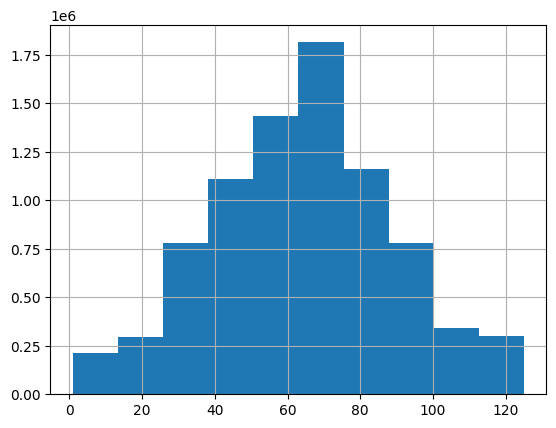

In [33]:
ratings_ba.rating.apply(lambda x: x**3).hist()
ratings_ba['zscore'] = ratings_ba['rating'].apply(lambda x: x**3)
ratings_ba['zscore'] = (ratings_ba['zscore']-ratings_ba['zscore'].mean())/ratings_ba['zscore'].std()

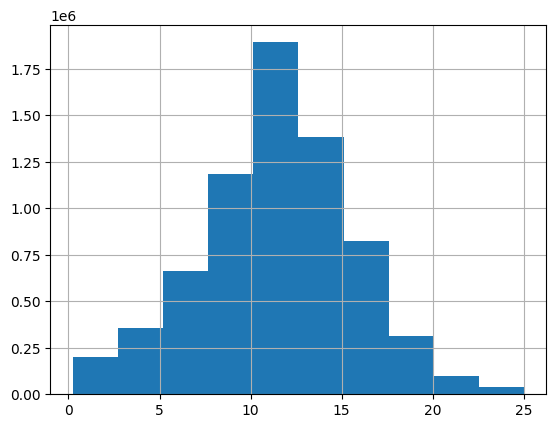

In [34]:
ratings_rb.rating.apply(lambda x: x**2).hist()
ratings_rb['zscore'] = ratings_rb['rating'].apply(lambda x: x**2)
ratings_rb['zscore'] = (ratings_rb['zscore']-ratings_rb['zscore'].mean())/ratings_rb['zscore'].std()

## Save transformed ratings

In [35]:
ratings_ba.sample(frac=0.1, random_state=42).to_pickle('./variables/transformed_ratings_ba.pkl')
ratings_rb.sample(frac=0.1, random_state=42).to_pickle('./variables/transformed_ratings_rb.pkl')
ratings_ba.sample(frac=1.0, random_state=42).to_pickle('./variables/transformed_ratings_ba_full.pkl')
ratings_rb.sample(frac=1.0, random_state=42).to_pickle('./variables/transformed_ratings_rb_full.pkl')

# Category analysis

## Loading and selecting data

In [36]:
df_ba = pd.read_pickle('./variables/transformed_ratings_ba.pkl')
df_rb = pd.read_pickle('./variables/transformed_ratings_rb.pkl')

In [41]:
df_ba_style = df_ba[['beer_id', 'beer_name', 'brewery_id', 'brewery_name', 'brewery_location', 'user_location', 'style','rating']]
df_rb_style = df_rb[['beer_id', 'beer_name', 'brewery_id', 'brewery_name', 'brewery_location', 'user_location', 'style','rating']]

# creating dataframe for styles/category analysis
df_styles_reviews = pd.concat([df_ba_style, df_rb_style]).reset_index().drop('index', axis=1).dropna()
df_styles_reviews['brewery_location'] = df_styles_reviews['brewery_location'].str.replace("United States, ", "")
df_styles_reviews['user_location'] = df_styles_reviews['user_location'].str.replace("United States, ", "")
df_styles_reviews = get_category(df_styles_reviews)

## Sorting by countries

In [42]:
user_loc_count = df_styles_reviews.groupby(['user_location'])['user_location'].count().sort_values(ascending=False)

# select countries with more than 100 reviews:
user_loc_count = user_loc_count[user_loc_count > 100]
print(f"Number of countries selected: {len(user_loc_count)}")

Number of countries selected: 119


## Finding favourite category

In [43]:
df_cat_location_dumm = pd.get_dummies(df_styles_reviews, columns=['category'])
best_cat_per_user_location = {}

# remove special characters in columns names
df_cat_location_dumm.columns = df_cat_location_dumm.columns.str.replace('category_', '')

# transform boolean values to int values for linear regression
for col in df_cat_location_dumm.drop(['beer_id', 'beer_name', 'brewery_name', 'brewery_location','user_location', 'brewery_id', 'rating','style'], axis=1).columns:
    df_cat_location_dumm[col] = df_cat_location_dumm[col] * 1

# perform linear regression on each location
columns= list(df_cat_location_dumm.drop(['beer_id', 'beer_name', 'user_location', 'brewery_name', 'brewery_location', 'brewery_id', 'rating', 'style'], axis=1).columns)
for idx, loc in enumerate(list(user_loc_count.keys())):
    df_reviews = df_cat_location_dumm[df_styles_reviews['user_location'] == loc]
    res = get_LR(df_reviews, columns)
    best_cat_per_user_location[loc] = res.params[res.params.keys() != 'Intercept'].sort_values(ascending=False)[0:3]

# save dictionary in pickle for other analysis
with open('./variables/best_cat_per_user_location.pickle', 'wb') as f:
    pickle.dump(best_cat_per_user_location, f, protocol=pickle.HIGHEST_PROTOCOL)

Index(['beer_id', 'beer_name', 'brewery_id', 'brewery_name',
       'brewery_location', 'user_location', 'style', 'rating', 'category'],
      dtype='object')


## Finding most reviewed category

In [44]:
most_reviewed_cat_per_user_location = {}
for idx, loc in enumerate(list(user_loc_count.keys())):
    most_reviewed_cat_per_user_location[loc] = df_styles_reviews[df_styles_reviews['user_location']==loc].groupby(['category'])['category'].count().sort_values(ascending=False)[:3]

## Finding local breweries

In [45]:
frac_reviews_per_brewery = {}

# loop on every location
for idx, loc in tqdm(enumerate(list(user_loc_count.keys())), total=len(list(user_loc_count.keys()))):

    # total number of reviews per brewery
    num_reviews_per_brewery = df_styles_reviews[df_styles_reviews['brewery_location'] == loc] \
    .groupby(['brewery_name'])['brewery_name'] \
    .count() \
    .sort_values(ascending=False)

    # number of local reviews per brewery
    num_reviews_per_brewery_loc = df_styles_reviews[(df_styles_reviews['brewery_location'] == loc) & (df_styles_reviews['user_location'] == loc)] \
    .groupby(['brewery_name'])['brewery_name'] \
    .count() \
    .sort_values(ascending=False)

    num_reviews_per_brewery.keys = num_reviews_per_brewery_loc.keys
    num_reviews_per_brewery = num_reviews_per_brewery.loc[num_reviews_per_brewery_loc.keys()]

    # fraction of local rewviews per brewery (50% and up)
    frac_reviews_per_brewery[loc] = num_reviews_per_brewery_loc.divide(num_reviews_per_brewery).sort_values(ascending=False)
    frac_reviews_per_brewery[loc] = frac_reviews_per_brewery[loc][frac_reviews_per_brewery[loc].values > .5]
    

100%|██████████| 119/119 [00:22<00:00,  5.28it/s]


In [46]:
# removing the locations with no "local" breweries (meaning that there is no brewery with high enough fraction of local reviewers)
init_num_loc = len(frac_reviews_per_brewery)
lst_empty_loc = []
for loc in frac_reviews_per_brewery:
    if len(frac_reviews_per_brewery[loc]) == 0:
        lst_empty_loc.append(loc)
for loc in lst_empty_loc:
    frac_reviews_per_brewery.pop(loc)
lst_locations = list(frac_reviews_per_brewery.keys())

print(f"{str(init_num_loc - len(lst_locations))} locations where removed")

13 locations where removed


## Looking for each country if local breweries is answering to local preferences

### Get the global average representation of each style

#### Find values for "difference" computation

In [47]:
retrain_glob_frac = False
if retrain_glob_frac:
    global_frac_per_cat = {}
    for cat in df_styles_reviews.category.unique():
        print(f"Compute for {cat}...")
        global_frac_per_cat[cat] = 0
        for brewery in list(df_styles_reviews.brewery_name.unique()):
            df_brewery = df_styles_reviews[df_styles_reviews['brewery_name'] == brewery][['category','brewery_name']]
            val = list(df_brewery[df_brewery['category'] == cat].groupby('category')['category'].count()/len(df_brewery))
            if val != []:
                global_frac_per_cat[cat] += val[0]
        global_frac_per_cat[cat] /= len(df_styles_reviews.brewery_name.unique())

    # save dictionaries
    with open('./variables/global_frac_per_cat.pickle', 'wb') as handle:
        pickle.dump(global_frac_per_cat, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('./variables/global_frac_per_cat.pickle', 'rb') as handle:
        global_frac_per_cat = pickle.load(handle)

#### Find lists for "zscore" computation

In [48]:
do_retrain_glob_frac_lst = False
if do_retrain_glob_frac_lst:
    global_frac_per_cat_lst = {}
    for cat in df_styles_reviews.category.unique():
        print(f"Compute for {cat}...")
        global_frac_per_cat_lst[cat] = []
        breweries = list(df_styles_reviews.brewery_name.unique())
        for brewery in breweries:
            df_brewery = df_styles_reviews[df_styles_reviews['brewery_name'] == brewery][['category','brewery_name']]
            val = list(df_brewery[df_brewery['category'] == cat].groupby('category')['category'].count()/len(df_brewery))
            if val != []:
                global_frac_per_cat_lst[cat].append(val[0])
            else:
                global_frac_per_cat_lst[cat].append(0)
                
    # save dictionaries
    with open('./variables/global_frac_per_cat_lst.pickle', 'wb') as handle:
        pickle.dump(global_frac_per_cat_lst, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('./variables/global_frac_per_cat_lst.pickle', 'rb') as handle:
        global_frac_per_cat_lst = pickle.load(handle)

In [49]:
# find mean and std for zscore
global_frac_per_cat_lst_mean = {}
global_frac_per_cat_lst_std = {}
for cat in df_styles_reviews.category.unique():
    global_frac_per_cat_lst_mean[cat] = np.mean(np.asarray(global_frac_per_cat_lst[cat]))
    global_frac_per_cat_lst_std[cat] = np.std(np.asarray(global_frac_per_cat_lst[cat]))

### Compare for each location

In [50]:
do_compare_loc = False
if do_compare_loc == True:
    # loop on every location
    frac_per_loc_per_cat = {}
    for idx, loc in tqdm(enumerate(lst_locations), total=len(lst_locations)):
        breweries = frac_reviews_per_brewery[loc].keys()
        cats = best_cat_per_user_location[loc].keys()
        frac_per_loc_per_cat[loc] = {}
        for cat in cats:
            frac_per_loc_per_cat[loc][cat] = 0
            for brewery in breweries:
                df_brewery = df_styles_reviews[df_styles_reviews['brewery_name'] == brewery][['category','brewery_name']]
                val = list(df_brewery[df_brewery['category'] == cat].groupby('category')['category'].count()/len(df_brewery))

                if val != []:
                    frac_per_loc_per_cat[loc][cat] += val[0]
                
            if len(breweries) > 0:
                frac_per_loc_per_cat[loc][cat] /= len(breweries)
            else:
                print("No breweries for : " + loc)
    
    # save library
    with open('./variables/frac_per_loc_per_cat.pickle', 'wb') as handle:
        pickle.dump(frac_per_loc_per_cat, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('./variables/frac_per_loc_per_cat.pickle', 'rb') as handle:
        frac_per_loc_per_cat = pickle.load(handle)

In [51]:
# compute diff and z-score
diff_frac_per_loc_per_cat = {}
zscore_frac_per_loc_per_cat = {}
for loc in lst_locations:
    diff_frac_per_loc_per_cat[loc] = {}
    zscore_frac_per_loc_per_cat[loc] = {}
    for cat in frac_per_loc_per_cat[loc]:
        diff_frac_per_loc_per_cat[loc][cat] = frac_per_loc_per_cat[loc][cat] - global_frac_per_cat[cat]
        zscore_frac_per_loc_per_cat[loc][cat] = (frac_per_loc_per_cat[loc][cat] - global_frac_per_cat_lst_mean[cat]) / global_frac_per_cat_lst_std[cat]

## Looking for each country if local breweries is answering to most reviewed

### Compare for each location

In [52]:
do_compare_loc_2 = False
if do_compare_loc_2 == True:
    # loop on every location
    frac_per_loc_per_cat_2 = {}
    for idx, loc in tqdm(enumerate(lst_locations), total=len(lst_locations)):
        breweries = frac_reviews_per_brewery[loc].keys()

        #styles = styles_rephrase(best_type_per_user_location[loc].keys())
        cats = most_reviewed_cat_per_user_location[loc].keys()
        frac_per_loc_per_cat_2[loc] = {}
        for cat in cats:
            frac_per_loc_per_cat_2[loc][cat] = 0
            for brewery in breweries:
                df_brewery = df_styles_reviews[df_styles_reviews['brewery_name'] == brewery][['category','brewery_name']]
                val = list(df_brewery[df_brewery['category'] == cat].groupby('category')['category'].count()/len(df_brewery))

                if val != []:
                    frac_per_loc_per_cat_2[loc][cat] += val[0]
                
            if len(breweries) > 0:
                frac_per_loc_per_cat_2[loc][cat] /= len(breweries)
            else:
                print("No breweries for : " + loc)
                
    # save library
    with open('./variables/frac_per_loc_per_cat_2.pickle', 'wb') as handle:
        pickle.dump(frac_per_loc_per_cat_2, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('./variables/frac_per_loc_per_cat_2.pickle', 'rb') as handle:
        frac_per_loc_per_cat_2 = pickle.load(handle)

In [53]:
# compute diff and zscore for most reviewes analysis
diff_frac_per_loc_per_cat_ana2 = {}
zscore_frac_per_loc_per_cat_ana2 = {}
for loc in lst_locations:
    diff_frac_per_loc_per_cat_ana2[loc] = {}
    zscore_frac_per_loc_per_cat_ana2[loc] = {}
    for cat in frac_per_loc_per_cat_2[loc]:
        diff_frac_per_loc_per_cat_ana2[loc][cat] = frac_per_loc_per_cat_2[loc][cat] - global_frac_per_cat[cat]
        zscore_frac_per_loc_per_cat_ana2[loc][cat] = (frac_per_loc_per_cat_2[loc][cat] - global_frac_per_cat_lst_mean[cat]) / global_frac_per_cat_lst_std[cat]


## Show results

### Load and merge shapefiles

In [54]:
# Load shapefiles
world = gpd.read_file('./shapefiles/world-administrative-boundaries.zip')
states = gpd.read_file('./shapefiles/georef-united-states-of-america-state-millesime.zip')

# clean world
world_clean = world[world['name'] != 'United States of America'][['name','geometry']]
world_clean.name = world_clean.name.str.replace("U.K. of Great Britain and Northern Ireland", "England")

# clean states
states.ste_name = states.ste_name.str.replace("['", "")
states.ste_name = states.ste_name.str.replace("']", "")
states_clean = states[['ste_name','geometry']]
states_clean.rename({'ste_name':'name'}, inplace=True, axis=1)

# concatenate
shapefile = pd.concat([world_clean, states_clean], axis=0)

C:\Users\swann\AppData\Local\Temp\ipykernel_31116\4206423101.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_clean.rename({'ste_name':'name'}, inplace=True, axis=1)


### Show main category per location

In [55]:
sf_maincat = shapefile.copy()

# find main category
sf_maincat['main_cat'] = "None"
for loc in lst_locations:
    sf_maincat.loc[sf_maincat['name'] == loc, 'main_cat'] = best_cat_per_user_location[loc].keys()[0]

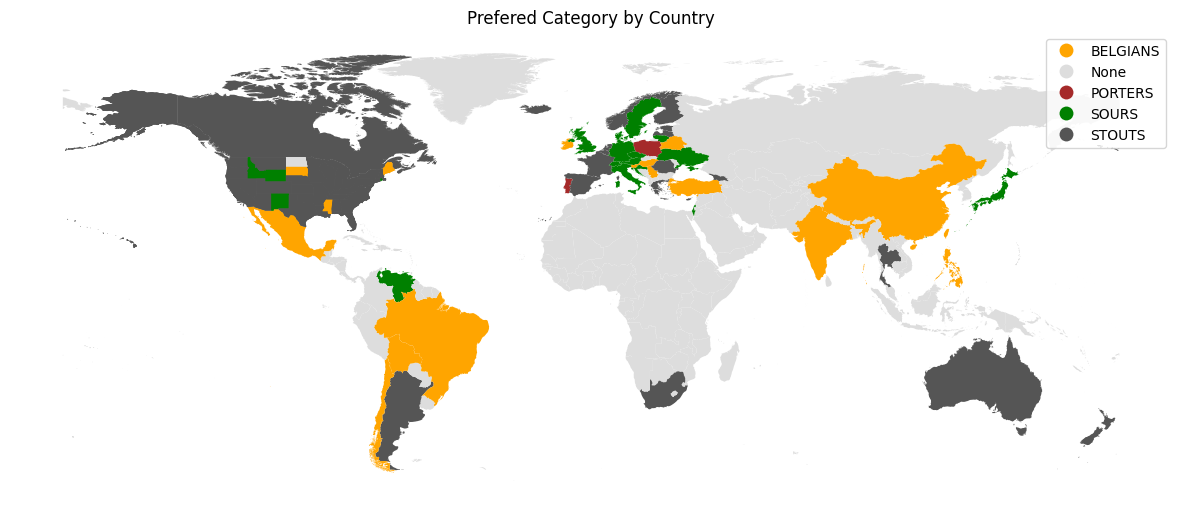

In [56]:
# color map
color_map = ['orange','#dddddd','brown','green','#555555']
# Plot the main predictor on a world map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
sf_maincat.plot(column='main_cat', cmap=colors.ListedColormap(color_map), ax=ax, legend=True, categorical=True)
plt.title('Prefered Category by Country')
plt.axis('off')
plt.savefig('../results/map_pref_cat.png')
plt.show()

### Show how breweries adapt to local preferences

In [57]:
sf_local_breweries = shapefile.copy()

# add zscore
sf_local_breweries['zscore'] = 0
for loc in lst_locations:
    sf_local_breweries.loc[sf_local_breweries['name'] == loc, 'zscore'] = np.sum(np.asarray(list(zscore_frac_per_loc_per_cat[loc].values())))/3

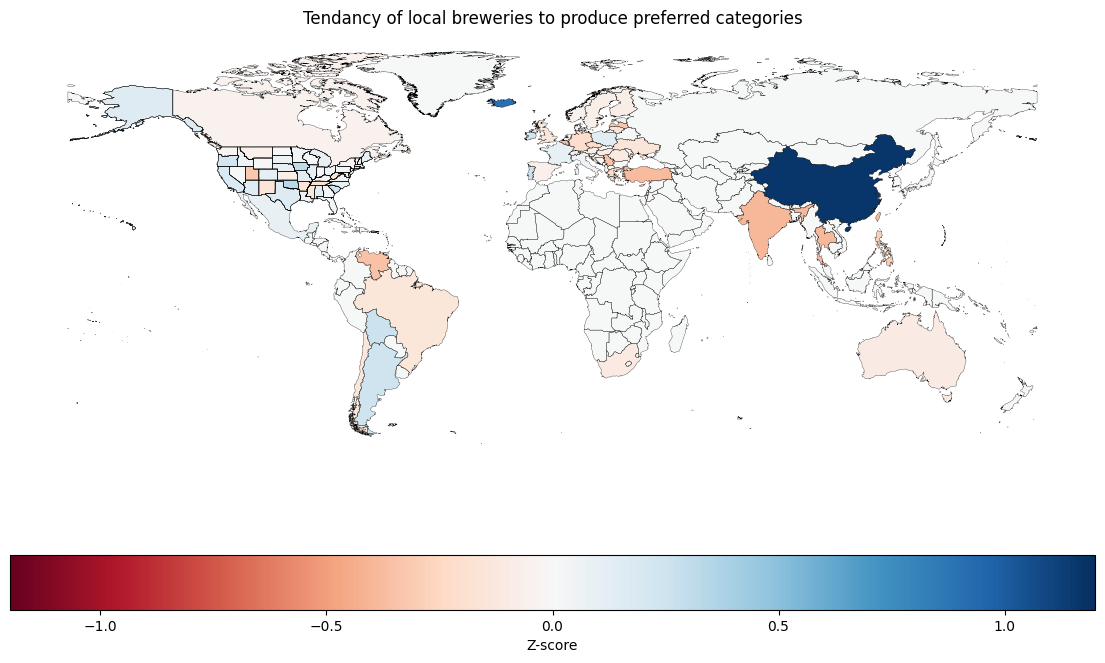

In [58]:
# Plot the main predictor on a world map
fig, ax = plt.subplots(1, 1, figsize=(14,8))

sf_maincat.boundary.plot(ax=ax, linewidth=.2, color='black')
im = sf_local_breweries.plot(column='zscore', cmap='RdBu', ax=ax, legend=True, legend_kwds={"label": "Z-score", "orientation": "horizontal"}, vmin=-1.2, vmax=1.2)

plt.title('Tendancy of local breweries to produce preferred categories')
plt.axis('off')
plt.savefig('../results/map_local_breweries.png')
plt.show()

### Show how breweries adapt to local most reviewed

In [59]:
sf_local_breweries2 = shapefile.copy()

# add zscore
sf_local_breweries2['zscore'] = 0
for loc in lst_locations:
    sf_local_breweries2.loc[sf_local_breweries2['name'] == loc, 'zscore'] = np.sum(np.asarray(list(zscore_frac_per_loc_per_cat_ana2[loc].values())))/3

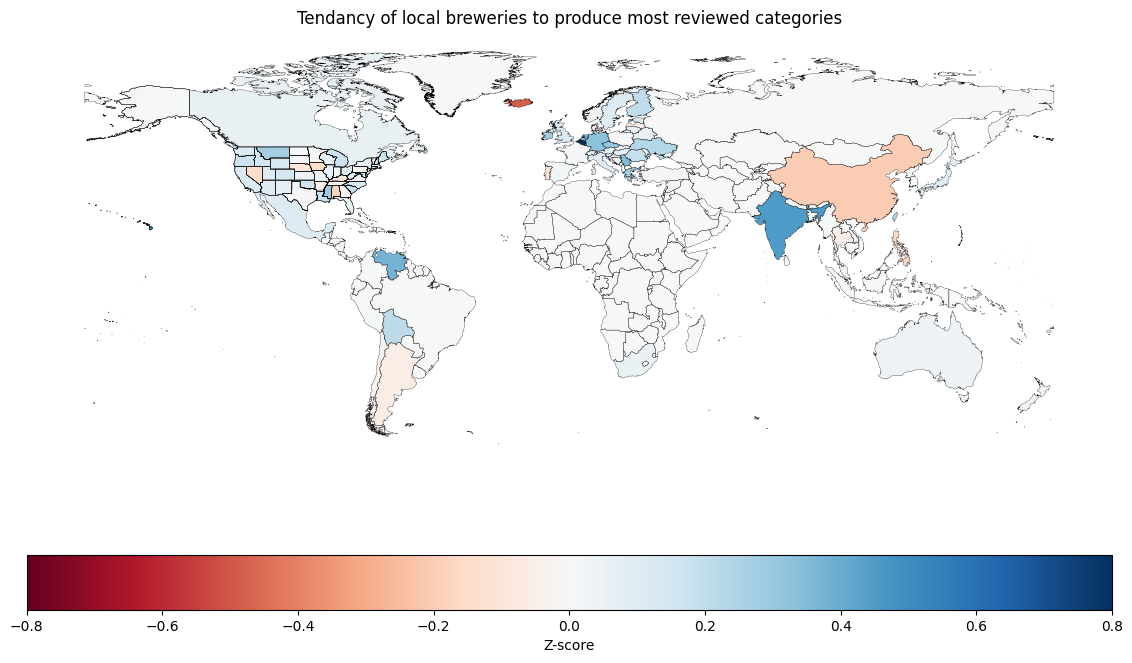

In [60]:
# Plot the main predictor on a world map
fig, ax = plt.subplots(1, 1, figsize=(14,8))

sf_local_breweries2.boundary.plot(ax=ax, linewidth=.2, color='black')
sf_local_breweries2.plot(column='zscore', cmap='RdBu', ax=ax, legend=True, legend_kwds={"label": "Z-score", "orientation": "horizontal"}, vmin=-0.8, vmax=0.8)

plt.title('Tendancy of local breweries to produce most reviewed categories')
plt.axis('off')
plt.savefig('../results/map_local_breweries_most_reviewed.png')
plt.show()

## Check for temporal trends between evolution of frac in reviews and frac in breweries propositions

### Find first review date for each beer

In [61]:
first_date_per_beer = {}
do_list_beers = False
if do_list_beers:
    # load full datasets
    df_ba_full = pd.read_pickle('./variables/transformed_ratings_ba_full.pkl')
    df_rb_full = pd.read_pickle('./variables/transformed_ratings_rb_full.pkl')
    
    # fing beers of beerdavocate (and also look for same beers in ratebeer)
    print('Looking into BeerAdvocate...')
    for idx, beer_id in tqdm(enumerate(list(df_ba_full.beer_id.unique())), total=len(list(df_ba_full.beer_id.unique()))):
        df_ba_beer = df_ba_full[df_ba_full['beer_id'] == beer_id][['beer_id', 'beer_name','date','style','brewery_name']]
        df_rb_beer = df_rb_full[df_rb_full['beer_id'] == beer_id][['beer_id', 'beer_name','date','style','brewery_name']]
        df_beer = pd.concat([df_ba_beer,df_rb_beer], axis=0)

        # add the first date appearing for this beer
        first_date_per_beer[beer_id] = df_beer.sort_values(by='date').iloc[0]

    # find beers of ratebeer that are not in beeradvocate
    print('Looking into RateBeer...')
    list_ba_beers = list(df_ba_full.beer_id.unique())
    list_rb_beers = list(df_rb_full.beer_id.unique())
    list_rb_to_process = list(set(list_rb_beers) - set(list_ba_beers))
    for idx, beer_id in tqdm(enumerate(list_rb_to_process), total=len(list_rb_to_process)):
        df_rb_beer = df_rb_full[df_rb_full['beer_id'] == beer_id][['beer_id', 'beer_name','date','style','brewery_name']]

        # add the first date appearing for this beer
        first_date_per_beer[beer_id] = df_rb_beer.sort_values(by='date').iloc[0]
    
    # save dictionary
    with open('./variables/first_date_per_beer.pickle','wb') as f:
        pickle.dump(first_date_per_beer, f, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('./variables/first_date_per_beer.pickle','rb') as f:
        first_date_per_beer = pickle.load(f)

In [62]:
# select only beers related to the subsample analysis
list_beers_analysis = list(df_styles_reviews.beer_id.unique())
first_date_per_beer = {key:first_date_per_beer[key] for key in list_beers_analysis}
df_first_date_per_beer = pd.DataFrame(first_date_per_beer).transpose().reset_index().drop('index',axis=1)

print(f"{len(df_first_date_per_beer)} beers selected")


208079 beers selected


### Compute time serie of frac per beers

In [63]:
# add category
df_first_date_per_beer = get_category(df_first_date_per_beer)


1 element removed because of unknown style


In [64]:
df_ba_date = df_ba[['date','style']]
df_rb_date = df_rb[['date','style']]
df_date_reviews = pd.concat([df_ba_date, df_rb_date]).reset_index().drop('index', axis=1).dropna()

# add category
df_date_reviews = get_category(df_date_reviews)

In [65]:
dic_date_cat_frac = {}
do_find_date_cat_frac = False
if do_find_date_cat_frac:
    lst_date = list(df_first_date_per_beer.date.unique())
    for date in tqdm(lst_date, total=len(lst_date)):
        dic_date_cat_frac[date] = []
        list_beers_date = list(df_first_date_per_beer[df_first_date_per_beer.date == date].beer_id.unique())
        for cat in list(df_first_date_per_beer.category.unique()):
            dic_date_cat_frac[date].append(len(df_first_date_per_beer[(df_first_date_per_beer.date == date) & (df_first_date_per_beer.category == cat)]) / len(list_beers_date))
    print(dic_date_cat_frac)

    # save dictionary:
    with open('./variables/dic_date_cat_frac.pickle', 'wb') as f:
        pickle.dump(dic_date_cat_frac, f, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('./variables/dic_date_cat_frac.pickle', 'rb') as f:
        dic_date_cat_frac = pickle.load(f)


In [66]:
# from dict to dataframe
df_date_cat_frac = pd.DataFrame(dic_date_cat_frac).transpose().reset_index().sort_values(by='index')
col_names = ["date"]
for x in list(df_date_reviews.category.unique()): col_names.append(x)
df_date_cat_frac.columns = col_names

# transform date to datetime format and average over quarter of year
df_date_cat_frac['date'] = pd.to_datetime(df_date_cat_frac['date'], unit='s')
df_date_cat_frac = df_date_cat_frac.groupby(pd.PeriodIndex(df_date_cat_frac['date'], freq="Q")).mean()


### Compute time serie of frac per breweries

In [67]:
df_cat_date_brewery_ba = df_ba[['beer_id', 'brewery_id', 'brewery_name', 'date', 'style']]
df_cat_date_brewery_rb = df_rb[['beer_id', 'brewery_id', 'brewery_name', 'date', 'style']]
df_cat_date_brewery = pd.concat([df_cat_date_brewery_ba, df_cat_date_brewery_rb]).reset_index().drop('index', axis=1).dropna()

# add category
df_cat_date_brewery = get_category(df_cat_date_brewery)

In [68]:
dic_cat_date_brewery = {}
do_findcatbrewery = False
if do_findcatbrewery:
    lst_date = list(df_cat_date_brewery.date.unique())
    for date in tqdm(lst_date, total=len(lst_date)):
        dic_cat_date_brewery[date] = []
        df_date_entries = df_cat_date_brewery[df_cat_date_brewery.date == date]
        breweries = df_date_entries[df_date_entries.date == date].brewery_name.unique()
        for cat in list(df_cat_date_brewery.category.unique()):
            frac = 0
            for brewery in breweries:
                frac += len(df_date_entries[(df_date_entries.category == cat) & (df_date_entries.brewery_name == brewery)])/len(df_date_entries[df_date_entries.brewery_name == brewery])
            frac /= len(breweries)
            dic_cat_date_brewery[date].append(frac)

    # save dictionary
    with open('./variables/dic_cat_date_brewery.pickle', 'wb') as f:
        pickle.dump(dic_cat_date_brewery, f, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('./variables/dic_cat_date_brewery.pickle', 'rb') as f:
        dic_cat_date_brewery = pickle.load(f)


In [69]:
# from dict to dataframe
df_cat_date_brewery_frac = pd.DataFrame(dic_cat_date_brewery).transpose().reset_index().sort_values(by='index')
col_names = ["date"]
for x in list(df_cat_date_brewery.category.unique()): col_names.append(x)
df_cat_date_brewery_frac.columns = col_names

# transform date to datetime format and average over quarter of year
df_cat_date_brewery_frac['date'] = pd.to_datetime(df_cat_date_brewery_frac['date'], unit='s')
df_cat_date_brewery_frac = df_cat_date_brewery_frac.groupby(pd.PeriodIndex(df_cat_date_brewery_frac['date'], freq="Q")).mean()

### Show results

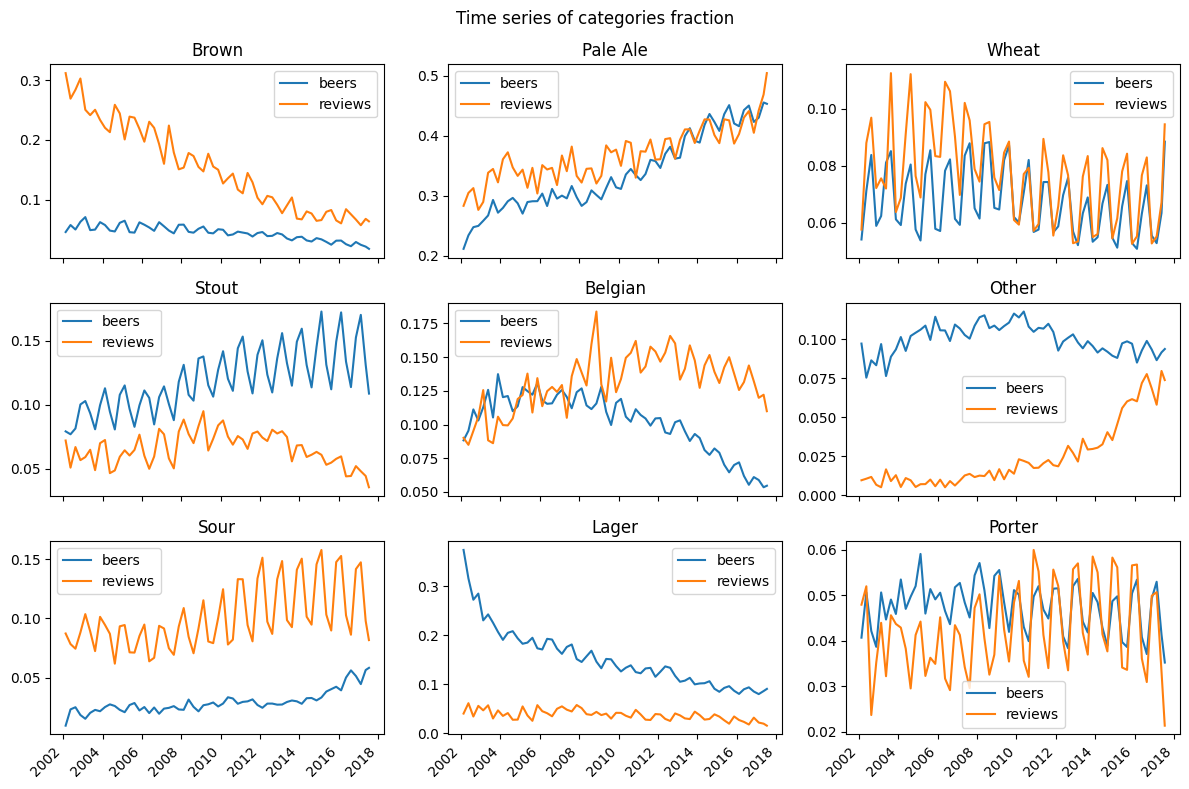

In [70]:
cat_array = np.asarray(list(df_cat_date_brewery.category.unique())).reshape((3,3))
dict_titles = {
    'BROWNS': 'Brown',
    'PALE_ALES': 'Pale Ale',
    'WHEATS': 'Wheat',
    'STOUTS': 'Stout',
    'BELGIANS': 'Belgian',
    'OTHER': 'Other',
    'SOURS': 'Sour',
    'LAGERS': 'Lager',
    'PORTERS': 'Porter',
}

# select min and max year for timespan of interest
min_year = 2002
max_year = 2017
df_cat_date_brewery_frac = df_cat_date_brewery_frac[(df_cat_date_brewery_frac.date.dt.year >= min_year) & (df_cat_date_brewery_frac.date.dt.year <= max_year)]
df_date_cat_frac = df_date_cat_frac[(df_date_cat_frac.date.dt.year >= min_year) & (df_date_cat_frac.date.dt.year <= max_year)]

# plot results
fig, axs = plt.subplots(3,3, figsize=(12,8), sharex=True)
for i in range(3):
    for j in range(3):
        axs[i,j].plot(df_cat_date_brewery_frac['date'], df_cat_date_brewery_frac[cat_array[i,j]], label='beers')
        axs[i,j].plot(df_date_cat_frac['date'], df_date_cat_frac[cat_array[i,j]], label='reviews')
        axs[i,j].set_title(dict_titles[cat_array[i,j]])
        axs[i,j].legend()
        for label in axs[i,j].get_xticklabels():
            label.set_rotation(45)
            label.set_ha('right')
plt.suptitle('Time series of categories fraction')
plt.tight_layout()
plt.savefig('../results/frac_time_series.png')

# Sentiment analysis

Basic Exploration

{'neg': 0.339, 'neu': 0.661, 'pos': 0.0, 'compound': -0.6249}
{'neg': 0.0, 'neu': 0.656, 'pos': 0.344, 'compound': 0.6369}


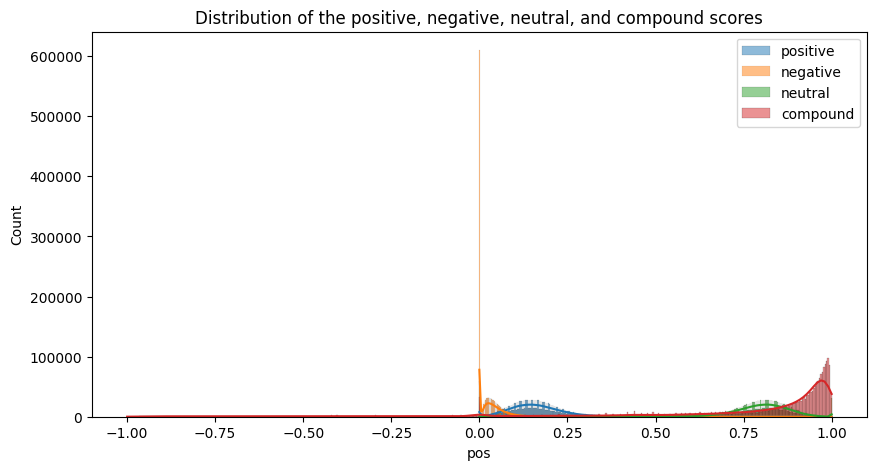

In [71]:
b_rev = 'this is the worst beer I have ever tasted'
g_rev = 'this is the best beer I have ever tasted'
analyzer = SentimentIntensityAnalyzer()
print(analyzer.polarity_scores(b_rev))
print(analyzer.polarity_scores(g_rev))

df_work_ba = pd.read_pickle('./variables/df_work_ba.pkl')

# plot the distribution of the positive, negative, neutral, and compound scores
plt.figure(figsize=(10, 5))
plt.title('Distribution of the positive, negative, neutral, and compound scores')

sns.histplot(data=df_work_ba, x='pos', label='positive', kde=True)
sns.histplot(data=df_work_ba, x='neg', label='negative', kde=True)
sns.histplot(data=df_work_ba, x='neu', label='neutral', kde=True)
sns.histplot(data=df_work_ba, x='compound', label='compound', kde=True)

plt.legend()
plt.show()

In [72]:
shapefile = set_map()


C:\Users\swann\AppData\Local\Temp\ipykernel_31116\4100819901.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_clean.rename({'ste_name':'name'}, inplace=True, axis=1)
C:\Users\swann\AppData\Local\Temp\ipykernel_31116\4100819901.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uk_clean.rename({'geo_label':'name'}, inplace=True, axis=1)


In [73]:
# copy shapefile into test
test = shapefile.copy()

#in the shapefile names, display all elements containeing 'Mold'
print("Elements of the shapefile that contain 'Slova' :")
display(test[test['name'].str.contains("Slova")])

Elements of the shapefile that contain 'Slova' :


,name,geometry
248,Slovakia,"POLYGON ((22.55805 49.07944, 22.55166 49.03943..."


Let us start with BeerAdvocate

In [74]:
#df_ba = pd.read_pickle('./variables/transformed_ratings_ba.pkl')
#df_rb = pd.read_pickle('./variables/transformed_ratings_rb.pkl')
#display(df_ba)
#display(df_rb)

In [75]:
# don't run it, instead load the pickle file './variables/df_work_ba.pkl'
# select columns from df, do sentiment analysis, keep only the ones with more than 5 appearences
#df_work_ba = data_prep(df_ba)
df_work_ba = pd.read_pickle('./variables/df_work_ba.pkl')


In [76]:
# save df_work_ba to pickle
#df_work_ba.to_pickle('./variables/df_work_ba.pkl')

In [77]:
# dont run it, instead load the pickle file './variables/df_work_rb.pkl'
#df_work_rb = data_prep(df_rb)
df_work_rb = pd.read_pickle('./variables/df_work_rb.pkl')

In [78]:
# save df_work_rb to pickle
#df_work_rb.to_pickle('./variables/df_work_rb.pkl')

Now that we have our basic df, let us start by breaking down the positivity and negativity by user_location

In [79]:


df_neg_ba, df_pos_ba = get_pn_df(df_work_ba, 'user_location')
#display(df_neg_ba)
#display(df_pos_ba)
df_neg_rb, df_pos_rb = get_pn_df(df_work_rb, 'user_location')

df_neg_ba_brwe, df_pos_ba_brwe = get_pn_df(df_work_ba, 'brewery_name')
df_neg_rb_brwe, df_pos_rb_brwe = get_pn_df(df_work_rb, 'brewery_name')

We now have our dfs by origin, countryand sentiment. We now plot those on a world map

Elements of the column user_location that aren't in the shapefile :


,user_location,neg,mean,median
2,Antarctica,"[0.024, 0.071, 0.0, 0.04, 0.0, 0.0, 0.023, 0.0...",0.035349,0.0260
3,Aotearoa,"[0.0, 0.023, 0.05, 0.043, 0.0, 0.107, 0.103, 0...",0.048484,0.0410
15,Bosnia and Herzegovina,"[0.0, 0.0, 0.115, 0.141, 0.228, 0.094, 0.0, 0....",0.059481,0.0420
34,Fiji Islands,"[0.019, 0.0, 0.0, 0.0, 0.0, 0.015, 0.036, 0.0,...",0.025500,0.0155
57,Macedonia,"[0.032, 0.0, 0.176, 0.059, 0.011, 0.073, 0.091...",0.048917,0.0340
77,South Georgia and South Sandwich Islands,"[0.0, 0.0, 0.043, 0.054, 0.106, 0.032, 0.039, ...",0.050688,0.0450
84,Tanzania,"[0.175, 0.218, 0.067, 0.0, 0.048, 0.0, 0.038, ...",0.081700,0.0720


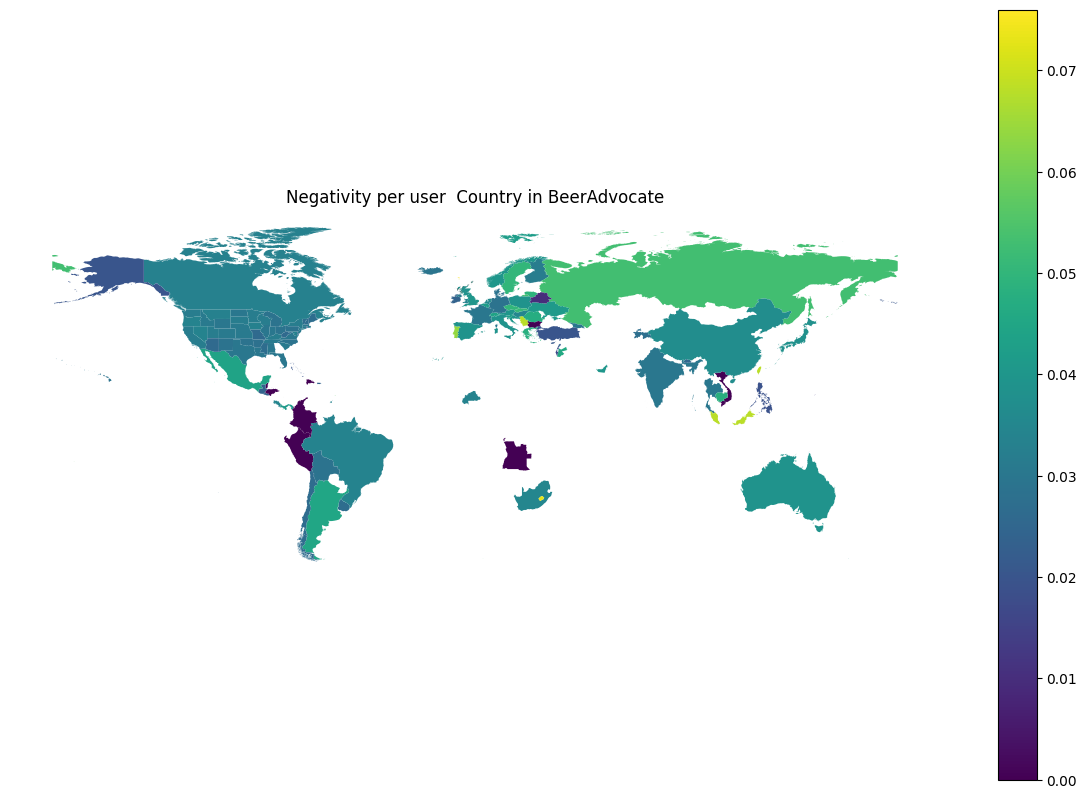

Elements of the column user_location that aren't in the shapefile :


,user_location,neg,mean,median
5,Ascension Island,"[0.118, 0.183, 0.176, 0.107, 0.045, 0.042, 0.1...",0.039112,0.000
16,Bosnia and Herzegovina,"[0.123, 0.351, 0.148, 0.204, 0.0, 0.0, 0.111, ...",0.040922,0.000
60,Laos,"[0.0, 0.0, 0.0, 0.0, 0.105, 0.0, 0.021, 0.039,...",0.036333,0.023
65,Macedonia,"[0.0, 0.062, 0.0, 0.04, 0.024, 0.053, 0.0, 0.0...",0.047605,0.043
82,North Korea,"[0.145, 0.0, 0.053, 0.0, 0.111, 0.28, 0.272, 0...",0.048720,0.000
87,Palestine,"[0.128, 0.0, 0.102, 0.05, 0.0, 0.0, 0.0, 0.121]",0.050125,0.025
97,Saint Helena,"[0.145, 0.052, 0.049, 0.077, 0.025, 0.109, 0.0...",0.079220,0.076
107,South Korea,"[0.063, 0.0, 0.05, 0.077, 0.0, 0.031, 0.0, 0.0...",0.049282,0.019
112,Tanzania,"[0.066, 0.028, 0.0, 0.0, 0.09, 0.0, 0.078, 0.0...",0.019962,0.000
172,Virgin Islands (U.S.),"[0.0, 0.0, 0.0, 0.169, 0.072, 0.034, 0.114, 0....",0.042077,0.017


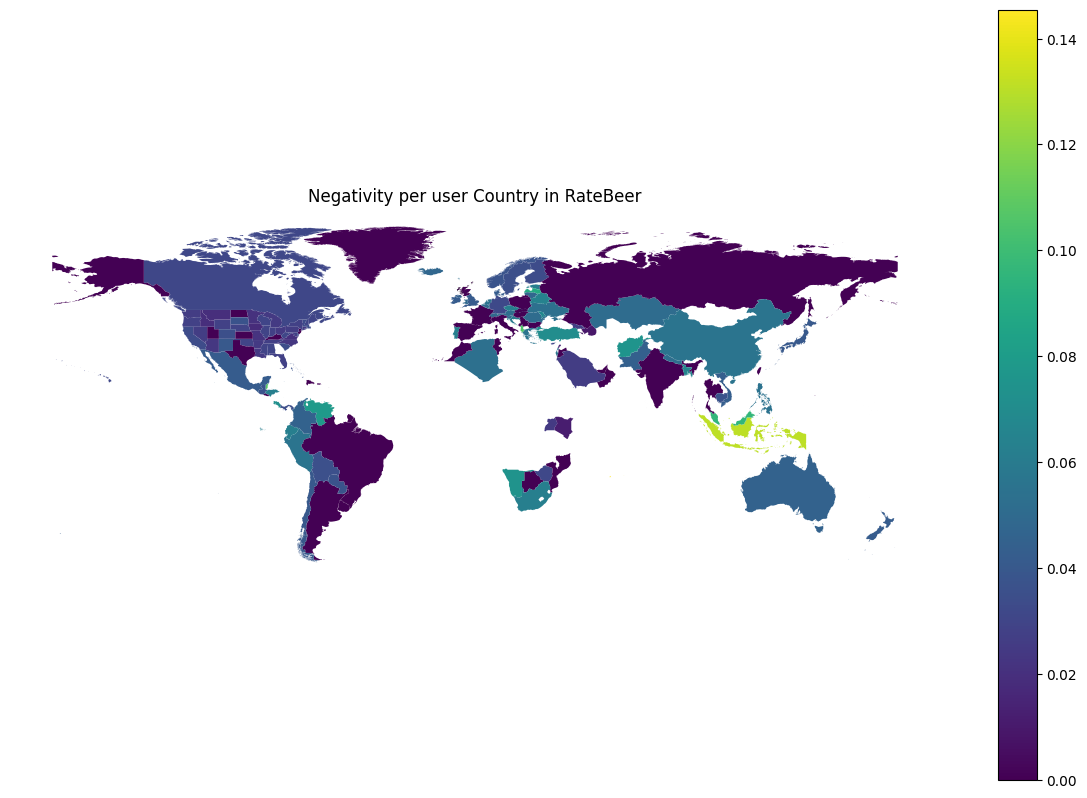

In [80]:
plot_map(df_neg_ba, shapefile, "Negativity per user ", "BeerAdvocate", 'median')
plot_map(df_neg_rb, shapefile, "Negativity per user", "RateBeer", 'median')


Elements of the column user_location that aren't in the shapefile :


,user_location,pos,mean,median
2,Antarctica,"[0.056, 0.143, 0.112, 0.052, 0.183, 0.194, 0.2...",0.139743,0.1360
3,Aotearoa,"[0.155, 0.092, 0.232, 0.111, 0.183, 0.138, 0.2...",0.146256,0.1360
15,Bosnia and Herzegovina,"[0.206, 0.052, 0.04, 0.08, 0.072, 0.059, 0.225...",0.133074,0.1120
34,Fiji Islands,"[0.145, 0.161, 0.169, 0.143, 0.054, 0.225, 0.1...",0.140170,0.1430
57,Macedonia,"[0.076, 0.18, 0.241, 0.175, 0.156, 0.153, 0.14...",0.156250,0.1545
77,South Georgia and South Sandwich Islands,"[0.149, 0.13, 0.147, 0.137, 0.083, 0.155, 0.08...",0.122938,0.1335
84,Tanzania,"[0.043, 0.081, 0.193, 0.12, 0.245, 0.206, 0.05...",0.156700,0.1590


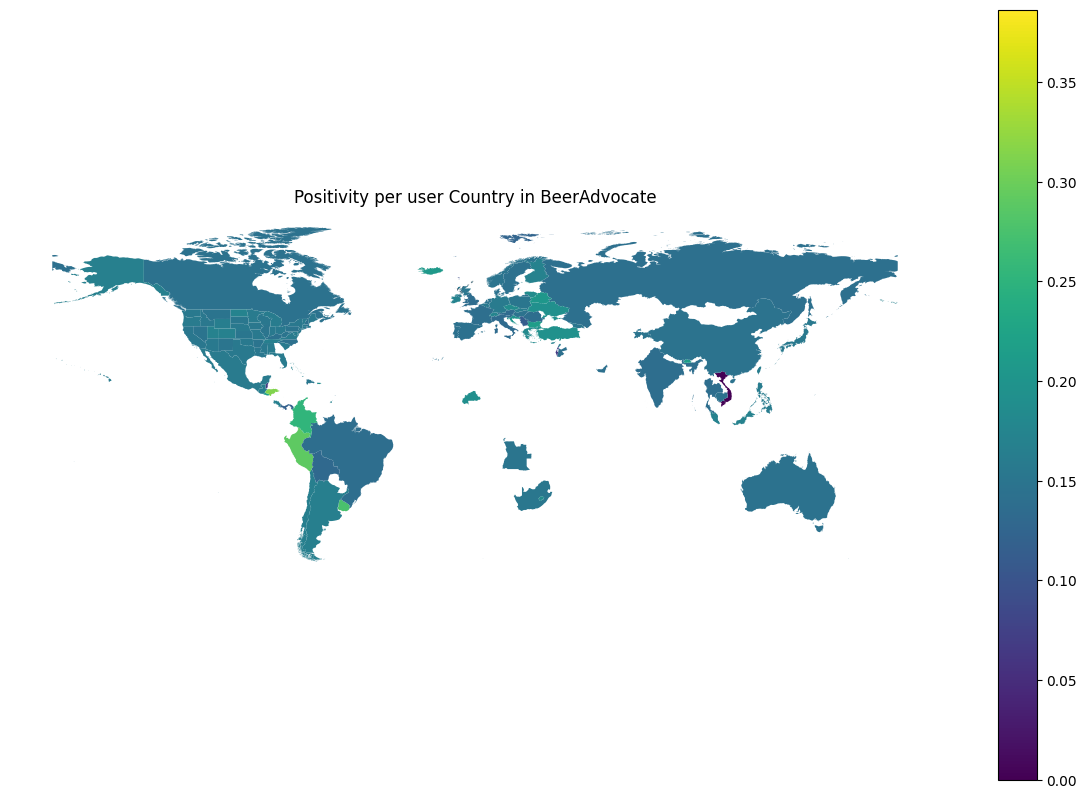

Elements of the column user_location that aren't in the shapefile :


,user_location,pos,mean,median
5,Ascension Island,"[0.04, 0.117, 0.071, 0.126, 0.136, 0.385, 0.04...",0.151517,0.1400
16,Bosnia and Herzegovina,"[0.192, 0.0, 0.045, 0.13, 0.0, 0.222, 0.0, 0.1...",0.131482,0.0330
60,Laos,"[0.288, 0.044, 0.049, 0.13, 0.116, 0.091, 0.09...",0.125000,0.0965
65,Macedonia,"[0.176, 0.278, 0.455, 0.086, 0.465, 0.369, 0.0...",0.189349,0.1760
82,North Korea,"[0.0, 0.221, 0.197, 0.208, 0.207, 0.0, 0.0, 0....",0.133195,0.1270
87,Palestine,"[0.153, 0.062, 0.275, 0.258, 0.261, 0.468, 0.4...",0.256750,0.2595
97,Saint Helena,"[0.122, 0.0, 0.0, 0.197, 0.118, 0.167, 0.226, ...",0.098417,0.0910
107,South Korea,"[0.116, 0.291, 0.167, 0.153, 0.293, 0.065, 0.1...",0.176475,0.1670
112,Tanzania,"[0.169, 0.157, 0.204, 0.128, 0.213, 0.214, 0.1...",0.180385,0.1785
172,Virgin Islands (U.S.),"[0.3, 0.21, 0.312, 0.108, 0.113, 0.233, 0.267,...",0.217667,0.2160


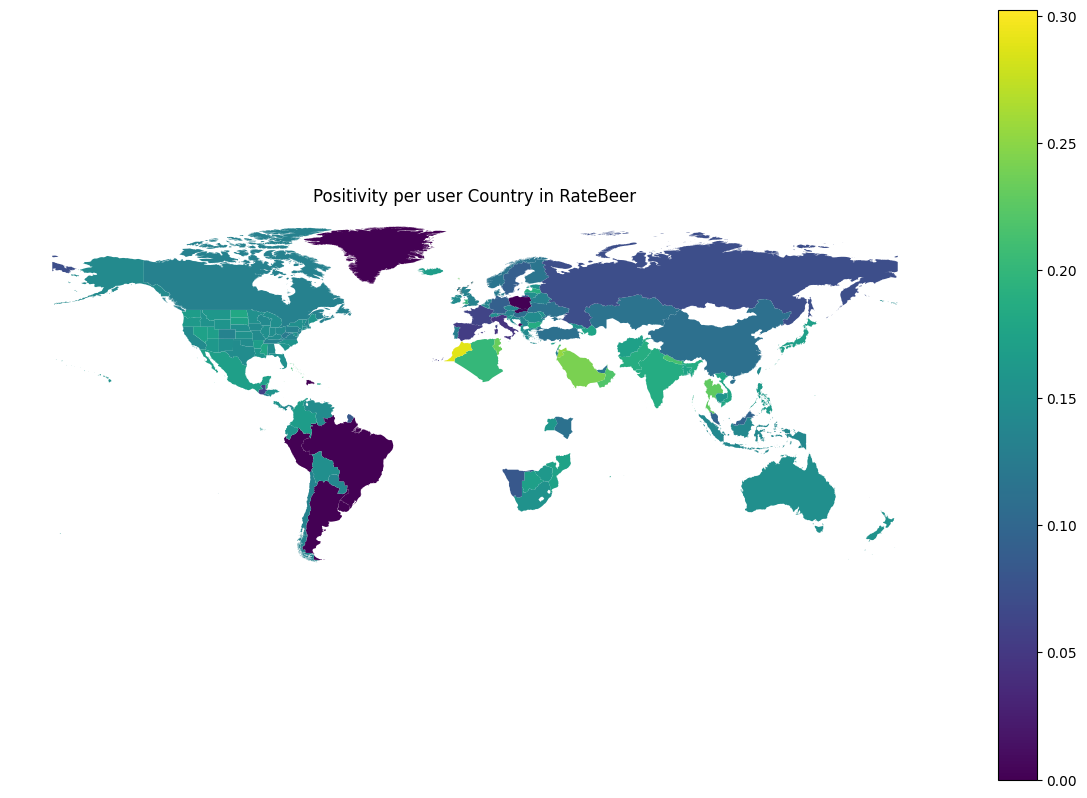

In [81]:
plot_map(df_pos_ba, shapefile, "Positivity per user", "BeerAdvocate", 'median')
plot_map(df_pos_rb, shapefile, "Positivity per user", "RateBeer",'median')

In BeerAdvocate we can observe that there is very few negativity in american reviews. In Europe and Asia people seem to leave comments with more negativity in them.
In RateBeer this is less visible.

In BeerAdvocate the positivity seems to be comparable around the world.
However in RateBeer american and african comments seem to contain more positivity than in their european counterparts.

Let us find 2 interresting breweries to explore, might not need for final version

In [82]:
# sort df_neg_ba_brwe by median
df_neg_ba_brwe = df_neg_ba_brwe.sort_values(by='median', ascending=False)
df_pos_ba_brwe = df_pos_ba_brwe.sort_values(by='median', ascending=False)
df_neg_rb_brwe = df_neg_rb_brwe.sort_values(by='median', ascending=False)
df_pos_rb_brwe = df_pos_rb_brwe.sort_values(by='median', ascending=False)

# only keep the lines with more than 50 elements in neg
df_neg_ba_brwe_sh = df_neg_ba_brwe[df_neg_ba_brwe['neg'].apply(len) > 50]
df_pos_ba_brwe_sh = df_pos_ba_brwe[df_pos_ba_brwe['pos'].apply(len) > 50]
df_neg_rb_brwe_sh = df_neg_rb_brwe[df_neg_rb_brwe['neg'].apply(len) > 50]
df_pos_rb_brwe_sh = df_pos_rb_brwe[df_pos_rb_brwe['pos'].apply(len) > 50]


display(df_neg_ba_brwe)
#display(df_pos_ba_brwe)
#display(df_neg_rb_brwe)
#display(df_pos_rb_brwe)

#display(df_neg_ba_brwe_sh)
#display(df_pos_ba_brwe_sh)
#display(df_neg_rb_brwe_sh)
#display(df_pos_rb_brwe_sh)

# save the 10 first and last lines of each datafram in a csv
# Get the head (first 10 rows) and tail (last 10 rows)
head_n = df_neg_ba_brwe_sh.head(10)
tail_n = df_neg_ba_brwe_sh.tail(10)
head_p = df_pos_ba_brwe_sh.head(10)
tail_p = df_pos_ba_brwe_sh.tail(10)

# Concatenate head and tail vertically
combined = pd.concat([head_n, tail_n, head_p, tail_p])

# Save the combined DataFrame to a CSV file
combined.to_csv('../results/df_ba_brwe.csv', index=False)

# Get the head (first 10 rows) and tail (last 10 rows)
head_n = df_neg_rb_brwe_sh.head(10)
tail_n = df_neg_rb_brwe_sh.tail(10)
head_p = df_pos_rb_brwe_sh.head(10)
tail_p = df_pos_rb_brwe_sh.tail(10)

# Concatenate head and tail vertically
combined = pd.concat([head_n, tail_n, head_p, tail_p])

# Save the combined DataFrame to a CSV file
combined.to_csv('../results/df_rb_brwe.csv', index=False)

# oder df_neg_ba_brwe_sh by length of neg
df_neg_rb_brwe_sh = df_neg_rb_brwe_sh.sort_values(by='neg', ascending=False)


#display the 20 first lines
display(df_neg_rb_brwe_sh.head(20))

# is 'Miller' in the brewery_name df_neg_rb_brwe_sh
print("is 'Miller' in the brewery_name df_neg_rb_brwe_sh :")
display(df_neg_rb_brwe_sh[df_neg_rb_brwe_sh['brewery_name'].str.contains("Miller")])

# display length of neg in Millers Brewery in df_neg_rb_brwe_sh
print("length of neg in Millers Brewery in df_neg_rb_brwe_sh :")
display(df_neg_rb_brwe_sh[df_neg_rb_brwe_sh['brewery_name'].str.contains("Millers Brewery")]['neg'].apply(len))

#display the following 20
#display(df_neg_ba_brwe_sh.iloc[20:40])

#display the following 20
#display(df_neg_ba_brwe_sh.iloc[40:60])

#display the following 20
#display(df_neg_ba_brwe_sh.iloc[60:80])


#sort df_neg_ba_brwe_sh by mean
df_neg_ba_brwe_sh = df_neg_ba_brwe_sh.sort_values(by='mean', ascending=False)

#display the 20 first lines
display(df_neg_ba_brwe_sh.head(20))
#display the last 20 lines
display(df_neg_ba_brwe_sh.tail(20))

#sort df_neg_rb_brwe_sh by median
df_neg_rb_brwe_sh = df_neg_rb_brwe_sh.sort_values(by='median', ascending=False)

#display the 20 first lines
display(df_neg_rb_brwe_sh.head(20))

#display the last 20 lines
display(df_neg_rb_brwe_sh.tail(20))

# in df_work_ba, nb of countries with Miller brewery_name
print("nb of countries with Miller brewery_name :")
display(df_work_ba[df_work_ba['brewery_name'] == 'Miller Brewing Co.']['user_location'].nunique())

# in df_work_ba, nb of countries with Anheuser-Bush brewery_name
print("nb of countries with Anheuser-Bush brewery_name :")
display(df_work_ba[df_work_ba['brewery_name'] == 'Anheuser-Busch']['user_location'].nunique())

# in df_work_ba, nb of countries with Heineken brewery_name
print("nb of countries with Heineken brewery_name :")
display(df_work_ba[df_work_ba['brewery_name'] == 'Heineken Nederland B.V.']['user_location'].nunique())

# in df_work_ba, nb of countries with Carlsberg brewery_name
print("nb of countries with Carlsberg brewery_name :")
display(df_work_ba[df_work_ba['brewery_name'] == 'Carlsberg Danmark A/S']['user_location'].nunique())

# in df_work_ba, nb of countries with Weihenstephan brewery_name
print("nb of countries with Weihenstephan brewery_name :")
display(df_work_ba[df_work_ba['brewery_name'] == 'Bayerische Staatsbrauerei Weihenstephan']['user_location'].nunique())

# in df_work_ba, nb of countries with Chimay brewery_name
print("nb of countries with Chimay brewery_name :")
display(df_work_ba[df_work_ba['brewery_name'] == 'Bières de Chimay']['user_location'].nunique())








,brewery_name,neg,mean,median
1857,Cerveza Frontera,"[0.08, 0.1, 0.217, 0.183, 0.134, 0.172]",0.147667,0.153
2383,Efes-Vitanta-Moldova Brewery S.A.,"[0.177, 0.077, 0.124, 0.156, 0.18, 0.108, 0.21...",0.131125,0.140
3909,Lovely Valley Beverage Factory,"[0.074, 0.173, 0.152, 0.076, 0.176, 0.135, 0.2...",0.136182,0.135
2836,Global Brands Ltd.,"[0.053, 0.214, 0.0, 0.481, 0.027, 0.134, 0.0, ...",0.132667,0.134
6224,Toboggan Brewing Co.,"[0.14, 0.033, 0.179, 0.0, 0.135, 0.133, 0.139,...",0.095111,0.133
...,...,...,...,...
4823,Pints Brewing Co.,"[0.0, 0.0, 0.02, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11...",0.016545,0.000
4063,Mastry's Brewing Company,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.000000,0.000
1277,Braugaststätte Döbler,"[0.0, 0.052, 0.02, 0.0, 0.0, 0.067, 0.0, 0.0]",0.017375,0.000
2235,Devils Brewery,"[0.0, 0.0, 0.0, 0.044, 0.0, 0.0]",0.007333,0.000


,brewery_name,neg,mean,median
1484,Bierfabrik Berlin,"[0.522, 0.063, 0.177, 0.04, 0.0, 0.03, 0.0, 0....",0.062441,0.0540
286,Ahold Czech Republic a.s.,"[0.467, 0.1, 0.0, 0.053, 0.0, 0.076, 0.1, 0.0,...",0.073637,0.0540
1015,Barda,"[0.451, 0.093, 0.091, 0.109, 0.095, 0.069, 0.0...",0.107714,0.0910
11514,Pinthouse Pizza,"[0.436, 0.06, 0.077, 0.081, 0.0, 0.175, 0.235,...",0.053778,0.0480
12929,Sandorf,"[0.419, 0.232, 0.057, 0.088, 0.057, 0.067, 0.0...",0.083147,0.0675
556,Apeldoornse Bierbrouwerij De Vlijt,"[0.419, 0.078, 0.0, 0.077, 0.092, 0.211, 0.0, ...",0.056482,0.0575
3455,Brouwerij de 7de Hemel,"[0.417, 0.064, 0.125, 0.129, 0.045, 0.0, 0.116...",0.053183,0.0480
6965,Great Flood Brewing Company,"[0.415, 0.0, 0.0, 0.028, 0.075, 0.0, 0.078, 0....",0.040557,0.0280
11423,Perła - Browary Lubelskie,"[0.413, 0.221, 0.299, 0.228, 0.188, 0.0, 0.036...",0.055644,0.0310
185,APU Company,"[0.403, 0.082, 0.084, 0.096, 0.0, 0.054, 0.0, ...",0.053651,0.0440


is 'Miller' in the brewery_name df_neg_rb_brwe_sh :


,brewery_name,neg,mean,median
4245,Cerveceria Hondureña (SABMiller),"[0.315, 0.0, 0.0, 0.035, 0.075, 0.0, 0.0, 0.14...",0.057747,0.0390
15008,Ursus Breweries (SABMiller),"[0.223, 0.037, 0.0, 0.088, 0.0, 0.104, 0.186, ...",0.067680,0.0570
4251,Cerveceria La Constancia (SABMiller),"[0.203, 0.086, 0.0, 0.162, 0.041, 0.069, 0.0, ...",0.072317,0.0550
4885,Compañia Cervecera de Canarias (SABMiller),"[0.146, 0.0, 0.296, 0.038, 0.0, 0.0, 0.045, 0....",0.069067,0.0590
4260,Cerveceria Nacional Panama (SABMiller),"[0.133, 0.068, 0.151, 0.151, 0.0, 0.048, 0.044...",0.066976,0.0630
7083,Grupo Empresarial Bavaria (SABMiller),"[0.131, 0.052, 0.034, 0.042, 0.146, 0.0, 0.036...",0.064609,0.0510
12842,Saint Archer Brewing Company &#40;MillerCoors&...,"[0.114, 0.0, 0.049, 0.061, 0.018, 0.1, 0.0, 0....",0.045895,0.0370
5629,Dreher Sörgyárak (SABMiller),"[0.093, 0.0, 0.1, 0.189, 0.088, 0.138, 0.133, ...",0.075509,0.0590
12424,Revolver Brewing &#40;MillerCoors&#41;,"[0.092, 0.011, 0.0, 0.0, 0.0, 0.0, 0.0, 0.166,...",0.038043,0.0000
3930,C.A.S.A. Isenbeck (SABMiller),"[0.09, 0.152, 0.211, 0.0, 0.0, 0.083, 0.073, 0...",0.070027,0.0610


length of neg in Millers Brewery in df_neg_rb_brwe_sh :


10113    155
Name: neg, dtype: int64

,brewery_name,neg,mean,median
1681,Camo Brewing Company,"[0.139, 0.277, 0.0, 0.095, 0.024, 0.108, 0.05,...",0.094642,0.0880
5883,Tall Tales Brewing Company,"[0.054, 0.127, 0.0, 0.0, 0.0, 0.039, 0.212, 0....",0.091230,0.0650
1964,Coastal Fog Brewing,"[0.144, 0.051, 0.061, 0.01, 0.065, 0.157, 0.02...",0.084587,0.0720
3647,Krönleins Bryggeri AB,"[0.059, 0.045, 0.244, 0.038, 0.12, 0.084, 0.18...",0.083034,0.0630
4540,Oettinger Brauerei,"[0.022, 0.025, 0.007, 0.045, 0.0, 0.102, 0.133...",0.080450,0.0495
1815,Cervecería Polar,"[1.0, 0.092, 0.09, 0.037, 0.07, 0.024, 0.057, ...",0.080032,0.0450
1908,Chili Beer Co.,"[0.127, 0.0, 0.016, 0.0, 0.06, 0.0, 0.022, 0.0...",0.077891,0.0690
4222,MobCraft Beer,"[0.0, 0.0, 0.066, 0.164, 0.037, 0.338, 0.336, ...",0.076654,0.0460
5464,Shaw Wallace & Company Ltd.,"[0.09, 0.091, 0.021, 0.18, 0.154, 0.859, 0.039...",0.076442,0.0560
5331,Saint Ides Brewing Company,"[0.041, 0.038, 0.096, 0.341, 0.0, 0.05, 0.075,...",0.076397,0.0590


,brewery_name,neg,mean,median
3337,Icicle Brewing Company,"[0.01, 0.01, 0.046, 0.0, 0.0, 0.0, 0.0, 0.023,...",0.024500,0.0215
3195,Hofbräu Kaltenhausen (Brau Union),"[0.036, 0.094, 0.031, 0.039, 0.0, 0.024, 0.0, ...",0.024471,0.0175
6739,Yonkers Brewing Co.,"[0.008, 0.0, 0.0, 0.025, 0.034, 0.031, 0.0, 0....",0.024352,0.0245
1479,Brouwerij Rodenbach N.V.,"[0.052, 0.019, 0.065, 0.0, 0.038, 0.0, 0.029, ...",0.024289,0.0190
6417,Urban Artifact,"[0.0, 0.0, 0.04, 0.031, 0.179, 0.012, 0.051, 0...",0.024123,0.0120
1769,Central State Brewing,"[0.016, 0.048, 0.0, 0.0, 0.0, 0.0, 0.051, 0.0,...",0.023613,0.0100
5434,Second Self Beer Company,"[0.018, 0.047, 0.0, 0.0, 0.028, 0.074, 0.0, 0....",0.023579,0.0000
2830,Glacier Brewhouse,"[0.0, 0.027, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",0.023569,0.0000
1366,BrickHouse Brewery,"[0.0, 0.077, 0.052, 0.055, 0.0, 0.0, 0.035, 0....",0.023438,0.0000
5850,"Swashbuckler Brewing Co, LTD","[0.068, 0.0, 0.067, 0.0, 0.04, 0.02, 0.0, 0.03...",0.023327,0.0170


,brewery_name,neg,mean,median
5533,Dolce Vela S.R.L.,"[0.211, 0.289, 0.157, 0.197, 0.098, 0.069, 0.2...",0.126458,0.1190
808,BIP-Beogradska Industrija Piva,"[0.158, 0.0, 0.263, 0.075, 0.092, 0.147, 0.114...",0.112920,0.1180
15046,Valge Pruulikoda,"[0.045, 0.125, 0.291, 0.115, 0.196, 0.034, 0.2...",0.133031,0.1015
10448,Mõtsalise Pruulikoda,"[0.0, 0.0, 0.11, 0.076, 0.078, 0.182, 0.146, 0...",0.098962,0.1005
15009,Urwibutso Enterprise,"[0.0, 0.226, 0.295, 0.13, 0.036, 0.0, 0.132, 0...",0.108190,0.0970
5953,Eridan,"[0.052, 0.05, 0.153, 0.135, 0.097, 0.239, 0.21...",0.100193,0.0970
11753,Pivzavod AO Hamovniki,"[0.0, 0.206, 0.174, 0.095, 0.027, 0.124, 0.212...",0.101931,0.0970
12396,Reschs (CUB),"[0.0, 0.0, 0.035, 0.147, 0.127, 0.035, 0.178, ...",0.109376,0.0950
7702,Holu,"[0.175, 0.15, 0.085, 0.12, 0.057, 0.206, 0.09,...",0.111949,0.0940
13242,Shirak Gyumri Beer-Malt Factory CJSC,"[0.169, 0.147, 0.151, 0.062, 0.0, 0.275, 0.189...",0.103049,0.0940


,brewery_name,neg,mean,median
13575,Spellbound Brewing,"[0.0, 0.0, 0.09, 0.062, 0.0, 0.124, 0.068, 0.0...",0.036836,0.0
3580,Browar Piwoteka,"[0.0, 0.0, 0.091, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",0.037212,0.0
10879,Octopi Brewing Company,"[0.0, 0.0, 0.091, 0.0, 0.0, 0.0, 0.088, 0.0, 0...",0.039340,0.0
913,Baerlic Brewing,"[0.0, 0.0, 0.091, 0.0, 0.0, 0.08, 0.0, 0.0, 0....",0.032902,0.0
8233,Jailbreak Brewing Company,"[0.017, 0.048, 0.0, 0.0, 0.0, 0.0, 0.058, 0.0,...",0.030195,0.0
5403,Desert Edge Brewery,"[0.0, 0.0, 0.092, 0.085, 0.0, 0.131, 0.047, 0....",0.036932,0.0
3621,Browar Wąsosz,"[0.157, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07, 0....",0.039171,0.0
9541,Lupine Brewing Company,"[0.0, 0.0, 0.093, 0.0, 0.0, 0.028, 0.0, 0.0, 0...",0.023933,0.0
10897,Odonata Beer Company,"[0.015, 0.023, 0.0, 0.0, 0.0, 0.017, 0.0, 0.07...",0.024037,0.0
8220,Jackdaw Brewery,"[0.158, 0.0, 0.065, 0.0, 0.033, 0.027, 0.034, ...",0.040805,0.0


nb of countries with Miller brewery_name :


88

nb of countries with Anheuser-Bush brewery_name :


102

nb of countries with Heineken brewery_name :


102

nb of countries with Carlsberg brewery_name :


83

nb of countries with Weihenstephan brewery_name :


101

nb of countries with Chimay brewery_name :


105

We will explore the sentiments about two large breweries, Millers and Weihenstephan around the world.
For that we will breakfown our df by origin, user_country, brewery and sentiment.

In [83]:
#display(df_work_ba)

# create a new df with brewery_name, user_location, neg, pos
df_ba_brwe_loc = df_work_ba[['brewery_name', 'user_location', 'neg', 'pos']]
df_rb_brwe_loc = df_work_rb[['brewery_name', 'user_location', 'neg', 'pos']]

# verifiy if Miller is in df_rb_brwe_loc
#print("Miller is in df_rb_brwe_loc :")
#display(df_rb_brwe_loc[df_rb_brwe_loc['brewery_name'] == 'Anheuser-Busch'])

# create a new df with all the unique countries and add a column negs and poss
df_ba_brwe_loc_unique = df_ba_brwe_loc[['user_location']].drop_duplicates()
df_ba_brwe_loc_unique['negs'] = ''
df_ba_brwe_loc_unique['poss'] = ''

# create a new df with all the unique countries and add a column negs and poss
df_rb_brwe_loc_unique = df_rb_brwe_loc[['user_location']].drop_duplicates()
df_rb_brwe_loc_unique['negs'] = ''
df_rb_brwe_loc_unique['poss'] = ''

# create df_rb_brwe_loc_unique_W, a copy of df_rb_brwe_loc_unique
df_rb_brwe_loc_unique_W = df_rb_brwe_loc_unique.copy()

# create df_ba_brwe_loc_unique_W, a copy of df_ba_brwe_loc_unique
df_ba_brwe_loc_unique_W = df_ba_brwe_loc_unique.copy()

# create df_rb_brwe_loc_unique_M, a copy of df_rb_brwe_loc_unique
df_rb_brwe_loc_unique_M = df_rb_brwe_loc_unique.copy()

# create df_ba_brwe_loc_unique_M, a copy of df_ba_brwe_loc_unique
df_ba_brwe_loc_unique_M = df_ba_brwe_loc_unique.copy()

#display(df_ba_brwe_loc_unique_M)
#display(df_rb_brwe_loc_unique_M)

In [85]:
# for each country, put the neg and pos of all appearences of Weihenstaphan in brewery_name and the country in negs and poss
for index, row in tqdm(df_ba_brwe_loc_unique.iterrows(), total=len(df_ba_brwe_loc_unique)):
    df_ba_brwe_loc_unique_W.at[index, 'negs'] = df_ba_brwe_loc[(df_ba_brwe_loc['user_location'] == row['user_location']) & (df_ba_brwe_loc['brewery_name'] == 'Bayerische Staatsbrauerei Weihenstephan')]['neg'].tolist()
    df_ba_brwe_loc_unique_W.at[index, 'poss'] = df_ba_brwe_loc[(df_ba_brwe_loc['user_location'] == row['user_location']) & (df_ba_brwe_loc['brewery_name'] == 'Bayerische Staatsbrauerei Weihenstephan')]['pos'].tolist()

for index, row in tqdm(df_rb_brwe_loc_unique.iterrows(), total=len(df_rb_brwe_loc_unique)):
    df_rb_brwe_loc_unique_W.at[index, 'negs'] = df_rb_brwe_loc[(df_rb_brwe_loc['user_location'] == row['user_location']) & (df_rb_brwe_loc['brewery_name'] == 'Bayerische Staatsbrauerei Weihenstephan')]['neg'].tolist()
    df_rb_brwe_loc_unique_W.at[index, 'poss'] = df_rb_brwe_loc[(df_rb_brwe_loc['user_location'] == row['user_location']) & (df_rb_brwe_loc['brewery_name'] == 'Bayerische Staatsbrauerei Weihenstephan')]['pos'].tolist()

#display(df_ba_brwe_loc_unique_W)
#display(df_rb_brwe_loc_unique_W)

100%|██████████| 221/221 [03:48<00:00,  1.04s/it]


In [ ]:

# for each country, put the neg and pos of all appearences of Miller in brewery_name and the country in negs and poss
for index, row in tqdm(df_ba_brwe_loc_unique.iterrows(), total=len(df_ba_brwe_loc_unique)):
    df_ba_brwe_loc_unique_M.at[index, 'negs'] = df_ba_brwe_loc[(df_ba_brwe_loc['user_location'] == row['user_location']) & (df_ba_brwe_loc['brewery_name'] == 'Miller Brewing Co.')]['neg'].tolist()
    df_ba_brwe_loc_unique_M.at[index, 'poss'] = df_ba_brwe_loc[(df_ba_brwe_loc['user_location'] == row['user_location']) & (df_ba_brwe_loc['brewery_name'] == 'Miller Brewing Co.')]['pos'].tolist()

for index, row in tqdm(df_rb_brwe_loc_unique.iterrows(), total=len(df_rb_brwe_loc_unique)):
    df_rb_brwe_loc_unique_M.at[index, 'negs'] = df_rb_brwe_loc[(df_rb_brwe_loc['user_location'] == row['user_location']) & (df_rb_brwe_loc['brewery_name'] == 'Millers Brewery')]['neg'].tolist()
    df_rb_brwe_loc_unique_M.at[index, 'poss'] = df_rb_brwe_loc[(df_rb_brwe_loc['user_location'] == row['user_location']) & (df_rb_brwe_loc['brewery_name'] == 'Millers Brewery')]['pos'].tolist()

#display(df_ba_brwe_loc_unique_M)
#display(df_rb_brwe_loc_unique_M)


100%|██████████| 221/221 [04:05<00:00,  1.11s/it]


In [ ]:
# remove the lines where negs are empty (neg and pos are always generated together)
df_ba_brwe_loc_unique_W = df_ba_brwe_loc_unique_W[df_ba_brwe_loc_unique_W['negs'].apply(len) > 0]

display(df_ba_brwe_loc_unique_W)

,user_location,negs,poss
0,"United States, Washington","[0.0, 0.0, 0.012, 0.0, 0.052, 0.02, 0.048, 0.0...","[0.269, 0.106, 0.149, 0.031, 0.119, 0.134, 0.1..."
1,"United States, New York","[0.0, 0.0, 0.012, 0.034, 0.049, 0.0, 0.055, 0....","[0.345, 0.125, 0.106, 0.211, 0.101, 0.276, 0.2..."
2,Northern Ireland,"[0.023, 0.015, 0.095, 0.0, 0.019, 0.0, 0.0, 0....","[0.211, 0.135, 0.073, 0.182, 0.205, 0.169, 0.1..."
5,"United States, North Carolina","[0.0, 0.014, 0.069, 0.043, 0.031, 0.015, 0.033...","[0.298, 0.097, 0.104, 0.188, 0.268, 0.064, 0.0..."
7,"United States, Illinois","[0.0, 0.086, 0.039, 0.024, 0.019, 0.023, 0.084...","[0.133, 0.222, 0.144, 0.19, 0.191, 0.181, 0.18..."
...,...,...,...
51142,Lithuania,[0.0],[0.221]
61210,Chile,[0.012],[0.188]
81987,Tajikistan,[0.02],[0.101]
87225,Tanzania,[0.055],[0.221]


In [ ]:


# remove the lines where negs are empty (neg and pos are always generated together)
df_rb_brwe_loc_unique_W = df_rb_brwe_loc_unique_W[df_rb_brwe_loc_unique_W['negs'].apply(len) > 0]

# remove the lines where negs are empty (neg and pos are always generated together)
df_ba_brwe_loc_unique_M = df_ba_brwe_loc_unique_M[df_ba_brwe_loc_unique_M['negs'].apply(len) > 0]

# remove the lines where negs are empty (neg and pos are always generated together)
df_rb_brwe_loc_unique_M = df_rb_brwe_loc_unique_M[df_rb_brwe_loc_unique_M['negs'].apply(len) > 0]

#display(df_ba_brwe_loc_unique_M)
#display(df_rb_brwe_loc_unique_M)
#display(df_rb_brwe_loc_unique_W)

Now that we have cleaned our dfs, we will compare the sentiment of the two breweries around the world.

In [ ]:
# take the mean of the negs and put in new column neg
df_ba_brwe_loc_unique_W['neg'] = df_ba_brwe_loc_unique_W['negs'].apply(np.mean)
# take the mean of the poss and put in new column pos
df_ba_brwe_loc_unique_W['pos'] = df_ba_brwe_loc_unique_W['poss'].apply(np.mean)

# take the mean of the negs and put in new column neg
df_rb_brwe_loc_unique_W['neg'] = df_rb_brwe_loc_unique_W['negs'].apply(np.mean)
# take the mean of the poss and put in new column pos
df_rb_brwe_loc_unique_W['pos'] = df_rb_brwe_loc_unique_W['poss'].apply(np.mean)

# take the mean of the negs and put in new column neg
df_ba_brwe_loc_unique_M['neg'] = df_ba_brwe_loc_unique_M['negs'].apply(np.mean)
# take the mean of the poss and put in new column pos
df_ba_brwe_loc_unique_M['pos'] = df_ba_brwe_loc_unique_M['poss'].apply(np.mean)

# take the mean of the negs and put in new column neg
df_rb_brwe_loc_unique_M['neg'] = df_rb_brwe_loc_unique_M['negs'].apply(np.mean)
# take the mean of the poss and put in new column pos
df_rb_brwe_loc_unique_M['pos'] = df_rb_brwe_loc_unique_M['poss'].apply(np.mean)



# create a df_comp with the country and the difference between the mean of the country and neg of df_ba_brwe_loc_unique
df_comp_neg_ba_W = df_ba_brwe_loc_unique_W[['user_location', 'neg']]
df_comp_neg_ba_W['diff'] = df_comp_neg_ba_W['neg'] - df_comp_neg_ba_W['neg'].mean()
df_comp_pos_ba_W = df_ba_brwe_loc_unique_W[['user_location', 'pos']]
df_comp_pos_ba_W['diff'] = df_comp_pos_ba_W['pos'] - df_comp_pos_ba_W['pos'].mean()

# create a df_comp with the country and the difference between the mean of the country and neg of df_rb_brwe_loc_unique
df_comp_rb_W = df_rb_brwe_loc_unique_W[['user_location', 'neg']]
df_comp_rb_W['diff'] = df_comp_rb_W['neg'] - df_comp_rb_W['neg'].mean()
df_comp_pos_rb_W = df_rb_brwe_loc_unique_W[['user_location', 'pos']]
df_comp_pos_rb_W['diff'] = df_comp_pos_rb_W['pos'] - df_comp_pos_rb_W['pos'].mean()

# create a df_comp with the country and the difference between the mean of the country and neg of df_ba_brwe_loc_unique
df_comp_neg_ba_M = df_ba_brwe_loc_unique_M[['user_location', 'neg']]
df_comp_neg_ba_M['diff'] = df_comp_neg_ba_M['neg'] - df_comp_neg_ba_M['neg'].mean()
df_comp_pos_ba_M = df_ba_brwe_loc_unique_M[['user_location', 'pos']]
df_comp_pos_ba_M['diff'] = df_comp_pos_ba_M['pos'] - df_comp_pos_ba_M['pos'].mean()

# create a df_comp with the country and the difference between the mean of the country and neg of df_rb_brwe_loc_unique
df_comp_rb_M = df_rb_brwe_loc_unique_M[['user_location', 'neg']]
df_comp_rb_M['diff'] = df_comp_rb_M['neg'] - df_comp_rb_M['neg'].mean()
df_comp_pos_rb_M = df_rb_brwe_loc_unique_M[['user_location', 'pos']]
df_comp_pos_rb_M['diff'] = df_comp_pos_rb_M['pos'] - df_comp_pos_rb_M['pos'].mean()



#display(df_ba_brwe_loc_unique)
#display(df_comp_pos_ba_W)
#display(df_comp_pos_rb_W)
#display(df_comp_pos_ba_M)
#display(df_comp_pos_rb_M)
#display(df_comp_neg_ba_W)
#display(df_comp_rb_W)
#display(df_comp_neg_ba_M)
#display(df_comp_rb_M)




C:\Users\ben\AppData\Local\Temp\ipykernel_9468\2504790235.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comp_neg_ba_W['diff'] = df_comp_neg_ba_W['neg'] - df_comp_neg_ba_W['neg'].mean()
C:\Users\ben\AppData\Local\Temp\ipykernel_9468\2504790235.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comp_pos_ba_W['diff'] = df_comp_pos_ba_W['pos'] - df_comp_pos_ba_W['pos'].mean()
C:\Users\ben\AppData\Local\Temp\ipykernel_9468\2504790235.py:31: SettingWithCopyWarning: 
A value is trying to be set on a

Elements of the column user_location that aren't in the shapefile :


C:\Users\ben\AppData\Local\Temp\ipykernel_9468\1590314689.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['user_location'] = df['user_location'].str.replace("United States, ", "")
C:\Users\ben\AppData\Local\Temp\ipykernel_9468\1590314689.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['user_location'] = df['user_location'].str.replace("Slovak Republic", "Slovakia")
C:\Users\ben\AppData\Local\Temp\ipykernel_9468\1590314689.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

,user_location,pos,diff
5832,Antarctica,0.080667,-0.04198


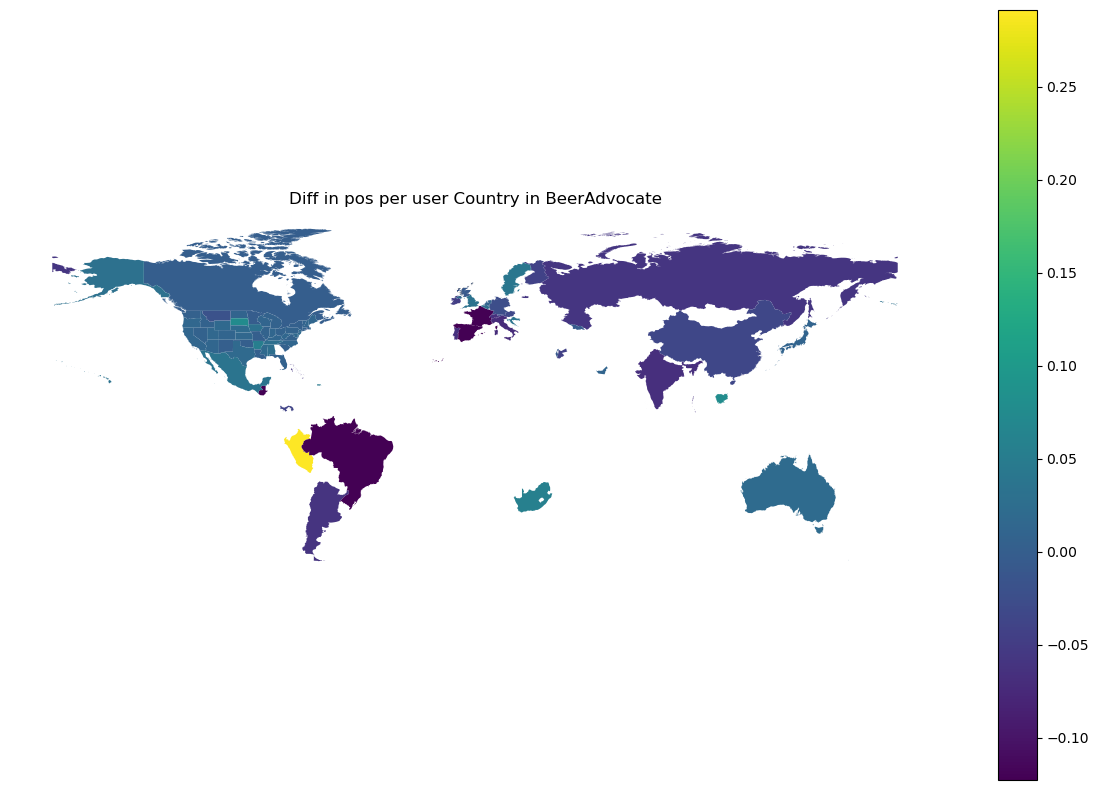

Elements of the column user_location that aren't in the shapefile :


C:\Users\ben\AppData\Local\Temp\ipykernel_9468\1590314689.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['user_location'] = df['user_location'].str.replace("United States, ", "")
C:\Users\ben\AppData\Local\Temp\ipykernel_9468\1590314689.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['user_location'] = df['user_location'].str.replace("Slovak Republic", "Slovakia")
C:\Users\ben\AppData\Local\Temp\ipykernel_9468\1590314689.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

,user_location,neg,diff
5832,Antarctica,0.058,-0.013161


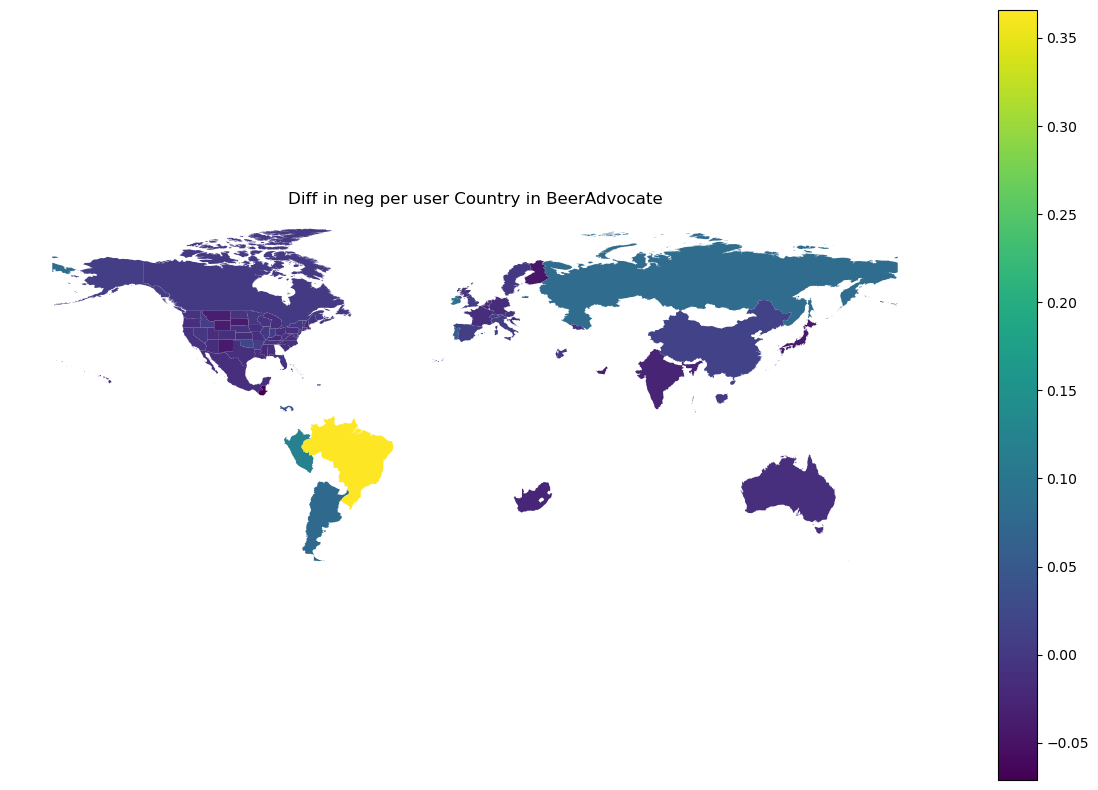

Elements of the column user_location that aren't in the shapefile :


C:\Users\ben\AppData\Local\Temp\ipykernel_9468\1590314689.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['user_location'] = df['user_location'].str.replace("United States, ", "")
C:\Users\ben\AppData\Local\Temp\ipykernel_9468\1590314689.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['user_location'] = df['user_location'].str.replace("Slovak Republic", "Slovakia")
C:\Users\ben\AppData\Local\Temp\ipykernel_9468\1590314689.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

,user_location,pos,diff


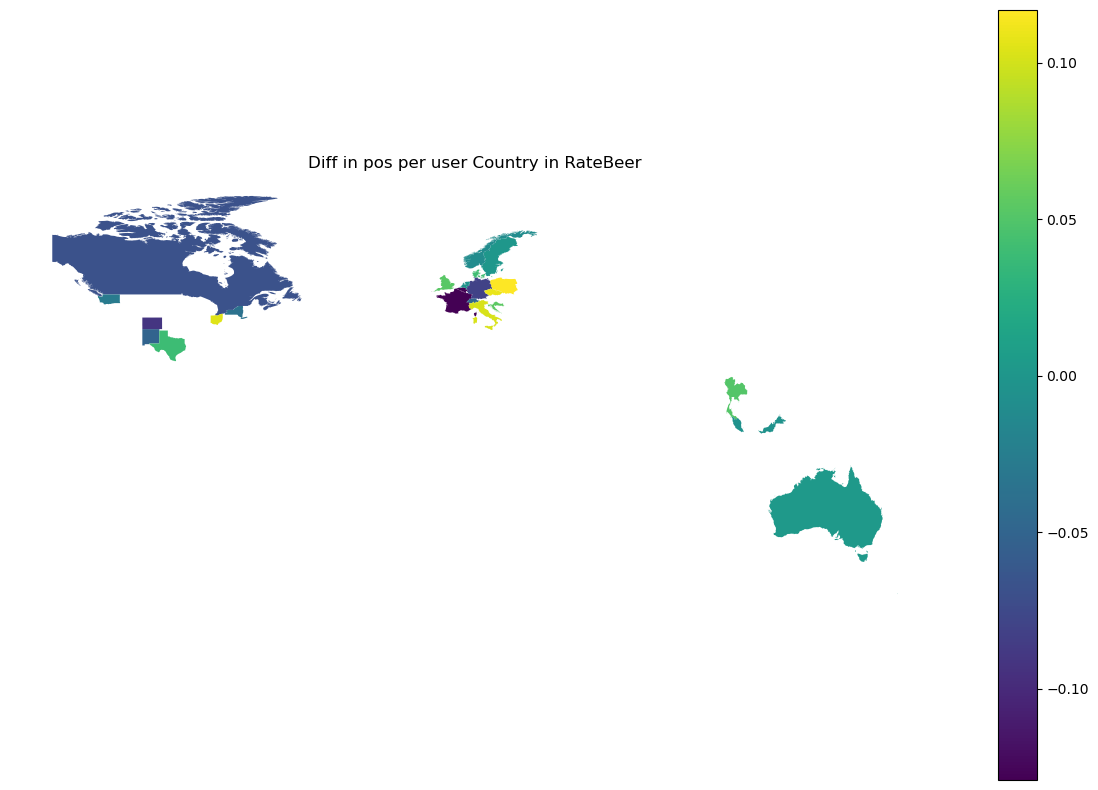

Elements of the column user_location that aren't in the shapefile :


C:\Users\ben\AppData\Local\Temp\ipykernel_9468\1590314689.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['user_location'] = df['user_location'].str.replace("United States, ", "")
C:\Users\ben\AppData\Local\Temp\ipykernel_9468\1590314689.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['user_location'] = df['user_location'].str.replace("Slovak Republic", "Slovakia")
C:\Users\ben\AppData\Local\Temp\ipykernel_9468\1590314689.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

,user_location,neg,diff


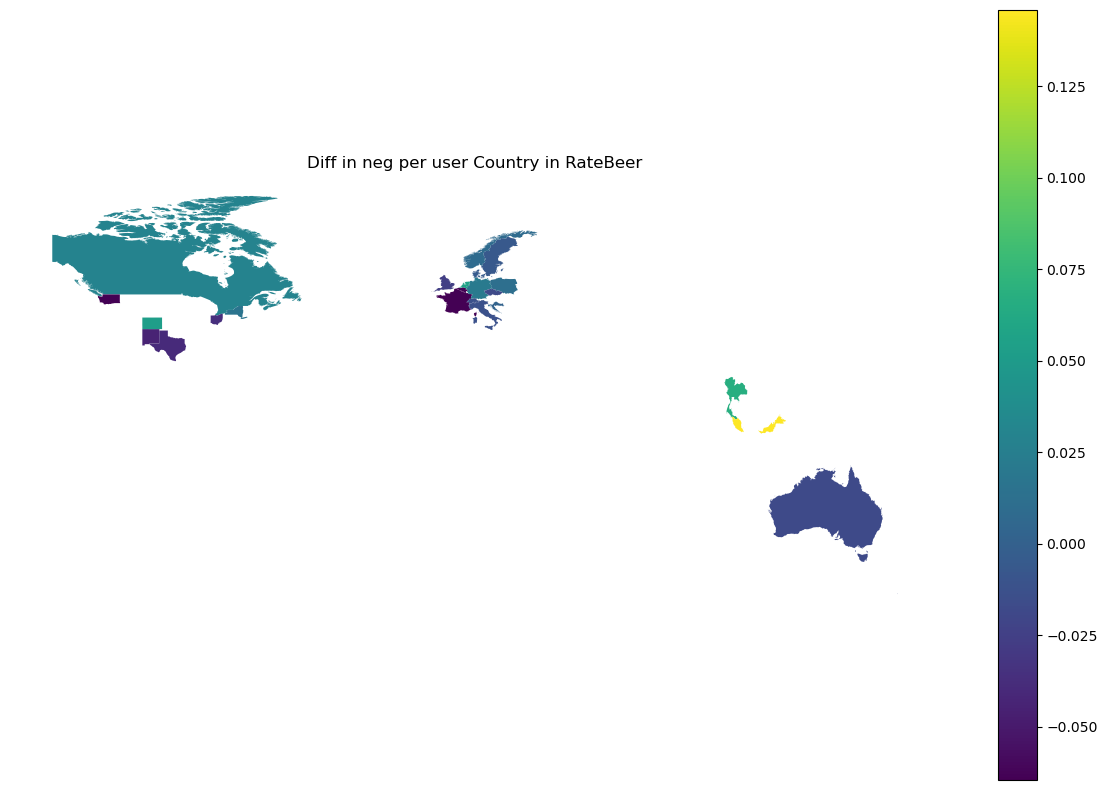

Elements of the column user_location that aren't in the shapefile :


C:\Users\ben\AppData\Local\Temp\ipykernel_9468\1590314689.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['user_location'] = df['user_location'].str.replace("United States, ", "")
C:\Users\ben\AppData\Local\Temp\ipykernel_9468\1590314689.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['user_location'] = df['user_location'].str.replace("Slovak Republic", "Slovakia")
C:\Users\ben\AppData\Local\Temp\ipykernel_9468\1590314689.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

,user_location,pos,diff
87225,Tanzania,0.221,0.032831


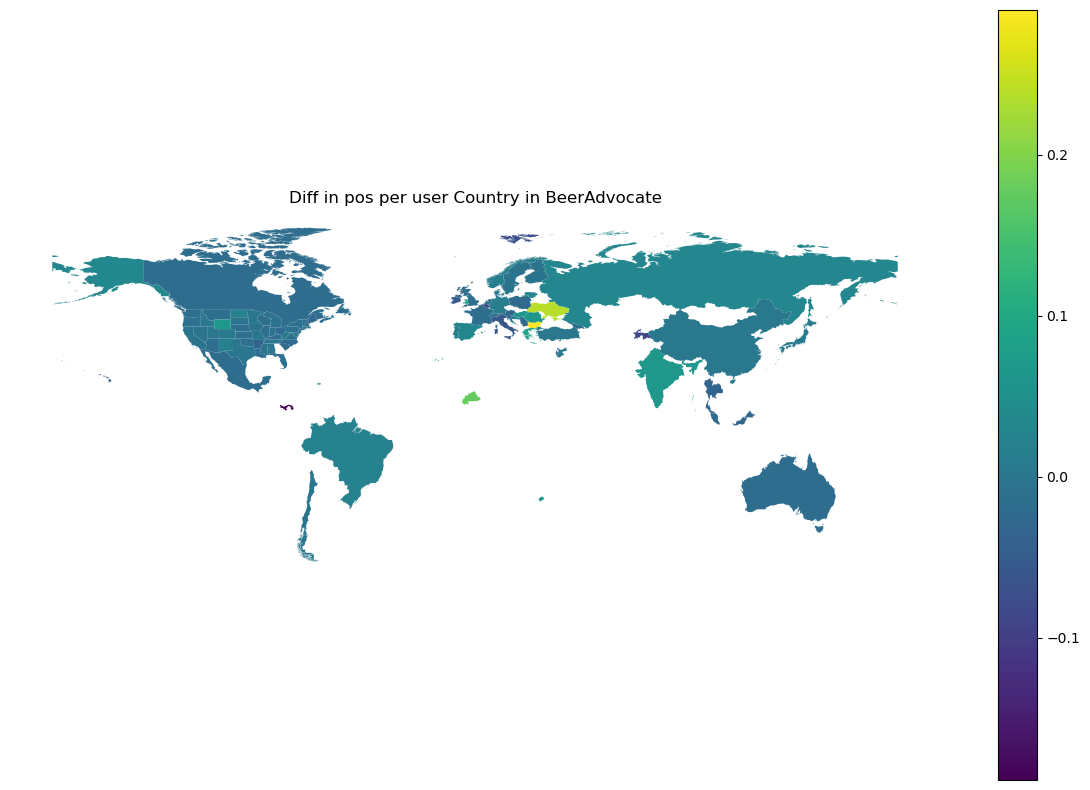

Elements of the column user_location that aren't in the shapefile :


C:\Users\ben\AppData\Local\Temp\ipykernel_9468\1590314689.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['user_location'] = df['user_location'].str.replace("United States, ", "")
C:\Users\ben\AppData\Local\Temp\ipykernel_9468\1590314689.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['user_location'] = df['user_location'].str.replace("Slovak Republic", "Slovakia")
C:\Users\ben\AppData\Local\Temp\ipykernel_9468\1590314689.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

,user_location,neg,diff
87225,Tanzania,0.055,0.029516


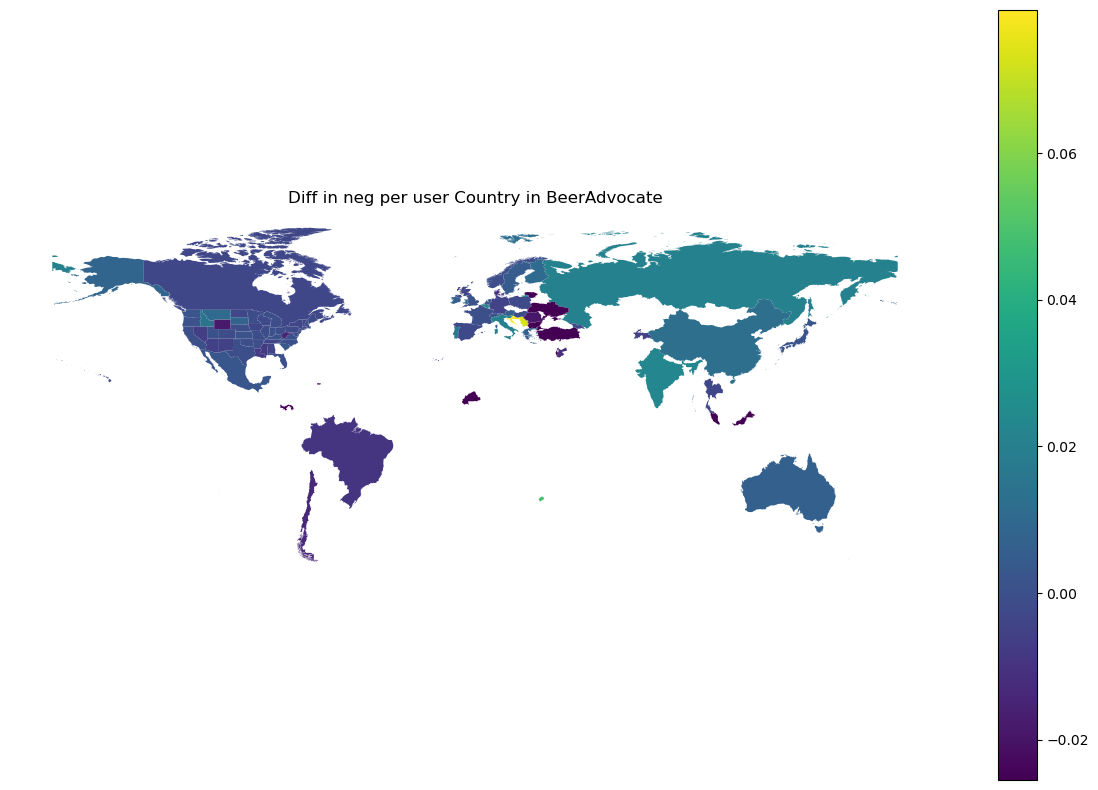

Elements of the column user_location that aren't in the shapefile :


C:\Users\ben\AppData\Local\Temp\ipykernel_9468\1590314689.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['user_location'] = df['user_location'].str.replace("United States, ", "")
C:\Users\ben\AppData\Local\Temp\ipykernel_9468\1590314689.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['user_location'] = df['user_location'].str.replace("Slovak Republic", "Slovakia")
C:\Users\ben\AppData\Local\Temp\ipykernel_9468\1590314689.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

,user_location,pos,diff
5121,Ascension Island,0.1918,0.014207
6304,North Korea,0.1470,-0.030593
6971,South Korea,0.2517,0.074107
465794,Saint Helena,0.1970,0.019407


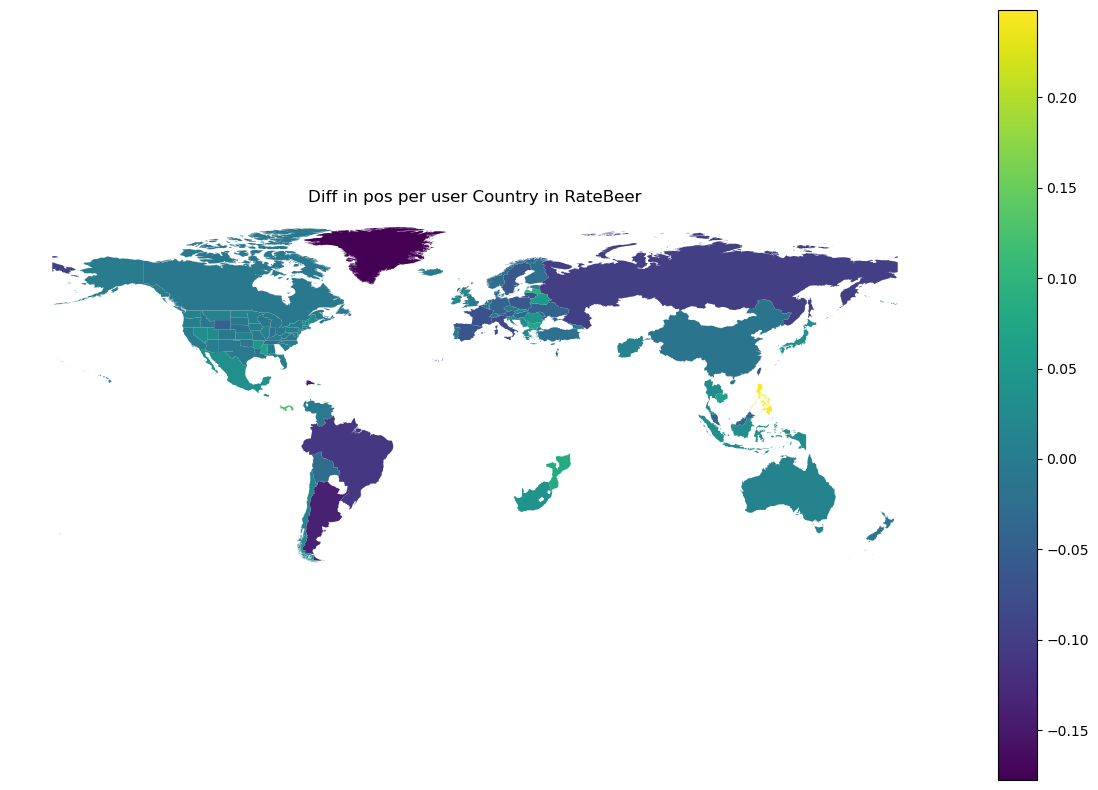

Elements of the column user_location that aren't in the shapefile :


C:\Users\ben\AppData\Local\Temp\ipykernel_9468\1590314689.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['user_location'] = df['user_location'].str.replace("United States, ", "")
C:\Users\ben\AppData\Local\Temp\ipykernel_9468\1590314689.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['user_location'] = df['user_location'].str.replace("Slovak Republic", "Slovakia")
C:\Users\ben\AppData\Local\Temp\ipykernel_9468\1590314689.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

,user_location,neg,diff
5121,Ascension Island,0.02520,-0.00857
6304,North Korea,0.01425,-0.01952
6971,South Korea,0.02920,-0.00457
465794,Saint Helena,0.07700,0.04323


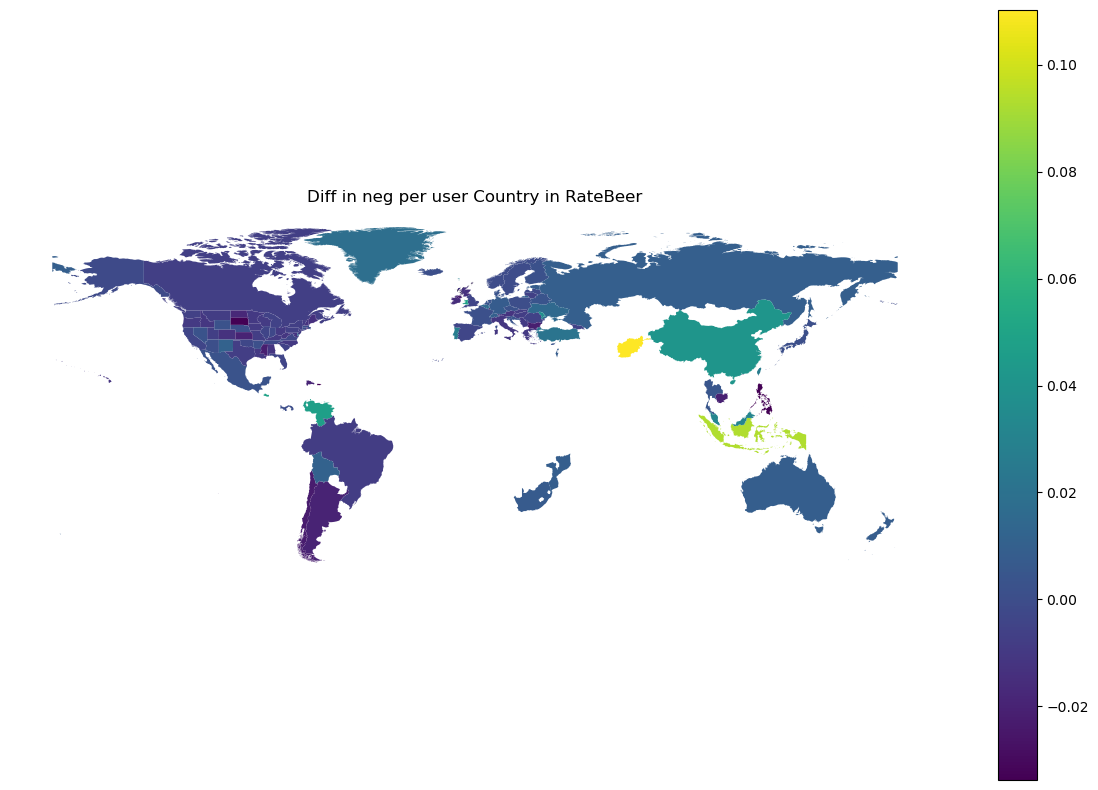

In [ ]:

#display(df_comp)
plot_map(df_comp_pos_ba_M, shapefile, "Diff in pos per user", "BeerAdvocate", 'diff')
plot_map(df_comp_neg_ba_M, shapefile, "Diff in neg per user", "BeerAdvocate", 'diff')
plot_map(df_comp_pos_rb_M, shapefile, "Diff in pos per user", "RateBeer", 'diff')
plot_map(df_comp_rb_M, shapefile, "Diff in neg per user", "RateBeer", 'diff')

plot_map(df_comp_pos_ba_W, shapefile, "Diff in pos per user", "BeerAdvocate", 'diff')
plot_map(df_comp_neg_ba_W, shapefile, "Diff in neg per user", "BeerAdvocate", 'diff')
plot_map(df_comp_pos_rb_W, shapefile, "Diff in pos per user", "RateBeer", 'diff')
plot_map(df_comp_rb_W, shapefile, "Diff in neg per user", "RateBeer", 'diff')

We can observe that for the Millers brewery, compared to the median resentiment (in the BeerAdvisor):
It contains more positivity in the US and less positivity in the rest of the world
It contains more negativity in South America 

For RateBeer, the variation is quite high around the world.


We can observe that for the Weihenstephan brewery, compared to the median resentiment:
It contains more positivity around the world
It contains more negativity in Asia and the Balcans,but less negativity in the rest of the world
It contains more positivity in the US, followed by Europe and South-East-Asia, it contains less positivity in South America.
It contains more negativity in South-East-Asia, but less negativity in the rest of the world

check for the styles for the 2 breweries


In [ ]:


# open as a dcitionary the file best_cat_per_user_location
with open('./variables/best_cat_per_user_location.pickle', 'rb') as file:
    dictionary_data = pickle.load(file)

#display(dictionary_data)

# transform the dictionary into a dataframe
df_best_cat = pd.DataFrame.from_dict(dictionary_data, orient='index')
df_best_cat.reset_index(inplace=True)
df_best_cat.rename({'index':'user_location', 0:'best_cat'}, inplace=True, axis=1)
#display(df_best_cat)

locations = df_best_cat['user_location'].unique()

# Creating an empty DataFrame to store the results
new_df = pd.DataFrame({'user_location': locations})

# Iterating through each row to extract the top 3 styles with non-NaN values
for idx, row in df_best_cat.iterrows():
    # Extracting the non-NaN values for each row and sorting them by descending order
    non_nan_styles = row.drop('user_location').dropna().sort_values(ascending=False)
    
    # Selecting the top 3 styles (or less if there are fewer than 3)
    top_styles = non_nan_styles[:3]
    
    # Filling the corresponding columns in the new DataFrame
    new_df.loc[idx, 'Top1'] = top_styles.index[0] if len(top_styles) >= 1 else None
    new_df.loc[idx, 'Top2'] = top_styles.index[1] if len(top_styles) >= 2 else None
    new_df.loc[idx, 'Top3'] = top_styles.index[2] if len(top_styles) >= 3 else None

display(new_df)



,user_location,Top1,Top2,Top3
0,California,STOUTS,SOURS,PALE_ALES
1,Pennsylvania,STOUTS,SOURS,BELGIANS
2,Canada,STOUTS,BELGIANS,SOURS
3,Illinois,STOUTS,SOURS,PALE_ALES
4,New York,STOUTS,SOURS,BELGIANS
...,...,...,...,...
114,Marshall Islands,BROWNS,PORTERS,PALE_ALES
115,Slovenia,BELGIANS,BROWNS,PORTERS
116,El Salvador,BROWNS,BELGIANS,PORTERS
117,Dominican Republic,BROWNS,PORTERS,BELGIANS


In [ ]:
# display all the styles of Miller Brewing Co. in BeerAdvocate
display(df_work_ba[df_work_ba['brewery_name'] == 'Miller Brewing Co.']['style'].unique())

# display all the styles of Anheuser-Bush in BeerAdvocate
display(df_work_ba[df_work_ba['brewery_name'] == 'Anheuser-Busch']['style'].unique())

# display all the styles of Weihenstephan in BeerAdvocate
display(df_work_ba[df_work_ba['brewery_name'] == 'Bayerische Staatsbrauerei Weihenstephan']['style'].unique())


array(['American Adjunct Lager', 'Herbed / Spiced Beer',
       'American Malt Liquor', 'Light Lager',
       'American Amber / Red Lager', 'American Amber / Red Ale',
       'American Blonde Ale', 'American Pale Wheat Ale',
       'Fruit / Vegetable Beer', 'Low Alcohol Beer'], dtype=object)

array(['American Amber / Red Lager', 'Fruit / Vegetable Beer',
       'Euro Pale Lager', 'Dunkelweizen', 'Irish Dry Stout',
       'German Pilsener', 'American Pale Lager', 'American Blonde Ale',
       'Herbed / Spiced Beer', 'Cream Ale', 'Doppelbock',
       'American Adjunct Lager', 'Light Lager', 'American Malt Liquor',
       'American Amber / Red Ale', 'Low Alcohol Beer',
       'Munich Helles Lager', 'American IPA', 'Pumpkin Ale',
       'American Double / Imperial Pilsner', 'Bock', 'Hefeweizen',
       'Black & Tan', 'Euro Dark Lager', 'American Pale Wheat Ale',
       'Irish Red Ale', 'Märzen / Oktoberfest', 'English Pale Ale',
       'American Porter', 'Winter Warmer', 'Oatmeal Stout',
       'American Pale Ale (APA)', 'Rye Beer', 'Witbier',
       'American Dark Wheat Ale', 'American Brown Ale', 'Czech Pilsener',
       'Kölsch'], dtype=object)

array(['Kellerbier / Zwickelbier', 'Hefeweizen', 'Märzen / Oktoberfest',
       'Low Alcohol Beer', 'Dunkelweizen', 'Maibock / Helles Bock',
       'Doppelbock', 'Kristalweizen', 'Weizenbock', 'Munich Helles Lager',
       'American Pale Ale (APA)', 'German Pilsener',
       'Munich Dunkel Lager', 'English Brown Ale'], dtype=object)

In [ ]:
# create new df_miller_ba with the column user_location, style, neg, pos of every appearence of Miller Brewing Co. in brewery_name in df_work_ba 
df_miller_ba = df_work_ba[['user_location', 'style', 'neg', 'pos']][df_work_ba['brewery_name'] == 'Miller Brewing Co.']


# create new df_weihen_ba with the column user_location, style, neg, pos of every appearence of Weihenstephan in brewery_name in df_work_ba
df_weihen_ba = df_work_ba[['user_location', 'style', 'neg', 'pos']][df_work_ba['brewery_name'] == 'Bayerische Staatsbrauerei Weihenstephan']


In [ ]:
def styles_rephrase(lst_styles):
    # replace some characters
    old_values = [' ', '-', '/', '(', ')', '&', ',', '____', '___', '__', 'style_']
    for val in old_values:
        lst_styles = lst_styles.str.replace(val,'_')
    
    # remove '_' if in first or last position of style name
    lst_styles = [x.rstrip('_') for x in lst_styles]
    lst_styles = [x.lstrip('_') for x in lst_styles]
    
    return lst_styles

In [ ]:
# rephrase styles
old_values = [' ', '-', '/', '\(', '\)', '\&', ',']
df_miller_ba.replace(
    to_replace={'style':old_values},
    value='_',
    regex=True,
    inplace=True,
)
df_miller_ba.replace(
    to_replace={'style':'____'},
    value='_',
    regex=True,
    inplace=True,
)
df_miller_ba.replace(
    to_replace={'style':'___'},
    value='_',
    regex=True,
    inplace=True,
)
df_miller_ba.replace(
    to_replace={'style':'__'},
    value='_',
    regex=True,
    inplace=True,
)
df_miller_ba['style'] = df_miller_ba['style'].str.strip('_')

# rephrase styles
old_values = [' ', '-', '/', '\(', '\)', '\&', ',']
df_weihen_ba.replace(
    to_replace={'style':old_values},
    value='_',
    regex=True,
    inplace=True,
)
df_weihen_ba.replace(
    to_replace={'style':'____'},
    value='_',
    regex=True,
    inplace=True,
)
df_weihen_ba.replace(
    to_replace={'style':'___'},
    value='_',
    regex=True,
    inplace=True,
)
df_weihen_ba.replace(
    to_replace={'style':'__'},
    value='_',
    regex=True,
    inplace=True,
)
df_weihen_ba['style'] = df_weihen_ba['style'].str.strip('_')



In [ ]:

# load csv
df_styles_to_cat = pd.read_csv('../data/preprocessed/styles_to_categories.csv', sep=';')

# add category for each review
df_miller_ba['category'] = "nothing"
for cat in df_styles_to_cat.columns:
    for style in df_styles_to_cat[cat].dropna():
        df_miller_ba.loc[df_miller_ba['style'] == style, 'category'] = cat

df_weihen_ba['category'] = "nothing"
for cat in df_styles_to_cat.columns:
    for style in df_styles_to_cat[cat].dropna():
        df_weihen_ba.loc[df_weihen_ba['style'] == style, 'category'] = cat



# in styles_to_cat change everything for strings, than replace all '_' by ' ' for all lines and the 9 fisrt columns
#df_styles_to_cat = df_styles_to_cat.astype(str)
#df_styles_to_cat = df_styles_to_cat.replace('_', ' ', regex=True)


# add category for each review
#df_miller_ba['category'] = "nothing"
#display(df_miller_ba)

# for each style in df_miller_ba, iterate through all the lines and the 9 first columns of df_styles_to_cat while the style is not found, and put the column name in category
#for index, row in tqdm(df_miller_ba.iterrows(), total=len(df_miller_ba)):
#    for col in df_styles_to_cat.columns[1:10]:
#        if row['style'] in df_styles_to_cat[col].tolist():
#            df_miller_ba.at[index, 'category'] = col




display(df_miller_ba)
display(df_weihen_ba)

# display all the categories of Miller Brewing Co. in BeerAdvocate
display(df_miller_ba['category'].unique())

#display the styles of categories == nothing
display(df_miller_ba[df_miller_ba['category'] == 'nothing']['style'].unique())

C:\Users\ben\AppData\Local\Temp\ipykernel_9468\526585330.py:2: DtypeWarning: Columns (0,1,4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_styles_to_cat = pd.read_csv('../data/preprocessed/styles_to_categories.csv', sep=';')


,user_location,style,neg,pos,category
435374,"United States, Iowa",American Adjunct Lager,0.045,0.249,nothing
435375,"United States, California",American Adjunct Lager,0.072,0.24,nothing
435376,"United States, Ohio",American Adjunct Lager,0.011,0.085,nothing
435377,"United States, Missouri",American Adjunct Lager,0.069,0.046,nothing
435378,"United States, Rhode Island",American Adjunct Lager,0.015,0.08,nothing
...,...,...,...,...,...
442206,"United States, Tennessee",Light Lager,0.055,0.084,nothing
442207,"United States, Virginia",Light Lager,0.216,0.104,nothing
442208,Canada,Light Lager,0.021,0.132,nothing
442209,"United States, Ohio",American Malt Liquor,0.049,0.131,nothing


,user_location,style,neg,pos,category
298553,"United States, Oklahoma",Kellerbier / Zwickelbier,0.025,0.099,nothing
298554,"United States, Vermont",Kellerbier / Zwickelbier,0.013,0.176,nothing
298555,"United States, Arizona",Kellerbier / Zwickelbier,0.015,0.117,nothing
298556,"United States, New Jersey",Kellerbier / Zwickelbier,0.093,0.181,nothing
298557,"United States, North Carolina",Kellerbier / Zwickelbier,0.0,0.298,nothing
...,...,...,...,...,...
307245,Spain,Märzen / Oktoberfest,0.042,0.128,nothing
307246,Italy,Hefeweizen,0.12,0.097,WHEATS
307247,Japan,Hefeweizen,0.017,0.209,WHEATS
307248,Belgium,Hefeweizen,0.045,0.125,WHEATS


array(['nothing'], dtype=object)

array(['American Adjunct Lager', 'Herbed / Spiced Beer',
       'American Malt Liquor', 'Light Lager',
       'American Amber / Red Lager', 'American Amber / Red Ale',
       'American Blonde Ale', 'American Pale Wheat Ale',
       'Fruit / Vegetable Beer', 'Low Alcohol Beer'], dtype=object)

In [ ]:
# create df_miller_ba_new with the unique user__locations and the mean neg and mean pos by category in m_neg and m_pos
df_miller_ba_new = df_miller_ba[['user_location', 'category', 'neg', 'pos']].groupby(['user_location', 'category']).mean().reset_index()
#display(df_miller_ba_new)

#display(df_ba_brwe_loc_unique_W)
#display(df_neg_ba)

# in df_miller_ba_sh only keep the lines with the categories according to new_df column top1 to top 3
df_miller_ba_sh = df_miller_ba_new[df_miller_ba_new['category'].isin(new_df['Top1'])]


display(df_miller_ba_sh)

# create df_weihen_ba_new with the unique user__locations and the mean neg and mean pos by category in m_neg and m_pos
df_weihen_ba_new = df_weihen_ba[['user_location', 'category', 'neg', 'pos']].groupby(['user_location', 'category']).mean().reset_index()
display(df_weihen_ba_new)

# in df_weihen_ba_sh only keep the lines with the categories according to new_df column top1
df_weihen_ba_sh = df_weihen_ba_new[df_weihen_ba_new['category'].isin(new_df['Top1'].tolist())]

# display all the unique categories in df_weihen_ba_sh
display(df_weihen_ba_sh['category'].unique())

display(df_weihen_ba_sh)


,user_location,category,neg,pos


,user_location,category,neg,pos
0,Australia,BROWNS,0.031655,0.178483
1,Australia,WHEATS,0.023534,0.176129
2,Australia,nothing,0.04098,0.158317
3,Austria,WHEATS,0.031333,0.154
4,Belgium,BROWNS,0.061,0.082
...,...,...,...,...
245,"United States, Wisconsin",nothing,0.025217,0.169
246,"United States, Wyoming",BROWNS,0.018,0.12
247,"United States, Wyoming",WHEATS,0.006833,0.278333
248,"United States, Wyoming",nothing,0.0,0.231


array(['BROWNS'], dtype=object)

,user_location,category,neg,pos
0,Australia,BROWNS,0.031655,0.178483
4,Belgium,BROWNS,0.061,0.082
10,Canada,BROWNS,0.032227,0.162818
14,China,BROWNS,0.098,0.181
19,England,BROWNS,0.037286,0.171714
...,...,...,...,...
234,"United States, Virginia",BROWNS,0.02804,0.17768
237,"United States, Washington",BROWNS,0.027974,0.161538
240,"United States, West Virginia",BROWNS,0.0102,0.3026
243,"United States, Wisconsin",BROWNS,0.0325,0.154591
